# LIBRARIES

In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import transforms

import optuna
from optuna.samplers import RandomSampler

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [2]:
from bokeh.plotting import figure, show
import bokeh.io
import bokeh.plotting
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
bokeh.io.output_notebook()

Loading BokehJS ...

# CART-POLE
Main reference: [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

## Experience replay (Replay Memory)

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html). 

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 128 neurons each) with an activation function (e.g. Tanh). 

Be sure to keep a linear output activation.

### Network definition

In [4]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim, out_features=128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=action_space_dim)
            )

    def forward(self, x):
        return self.linear(x)

### Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

#### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

NOTE: there is a difference wrt paper in that they do not exclude the best action when chosing the action at random

In [5]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

#### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [6]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)
        if len(net_out.shape)!=1:
            net_out=net_out[0]

    #print(net_out)


    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out.cpu() / temperature, dim=0).numpy()
    
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    #print(all_possible_actions)
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    

    return action, net_out.cpu().numpy()

state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

#### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax\_temperature}  = \text{initial\_temperature} * \text{exp\_decay}^i \qquad \text{for $i$ = 1, 2, ..., num\_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

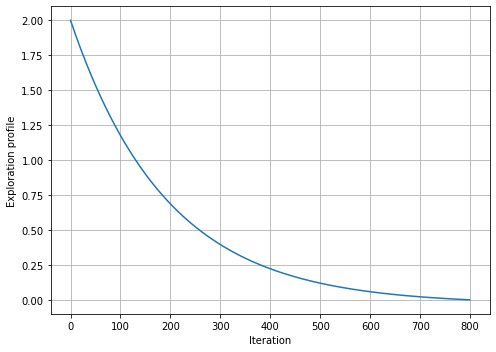

In [7]:

### Define exploration profile
def exp_exploration(initial_value=5, num_iterations=600, stepness=6, plott=False):
    if initial_value>1:
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * stepness) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    else:
        exp_decay = np.exp(np.log(initial_value) / num_iterations * stepness) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    exploration_profile=(exploration_profile-exploration_profile[-1]+1e-8)
    exploration_profile=exploration_profile*initial_value/exploration_profile[0]
    if plott:
        plt.figure(figsize=(7,5))
        plt.plot(exploration_profile)
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('Exploration profile')
        plt.tight_layout()

    return exploration_profile

exploration_profile= exp_exploration(initial_value=2, num_iterations=800, stepness=6, plott=True)

### Plot exploration profile


## Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

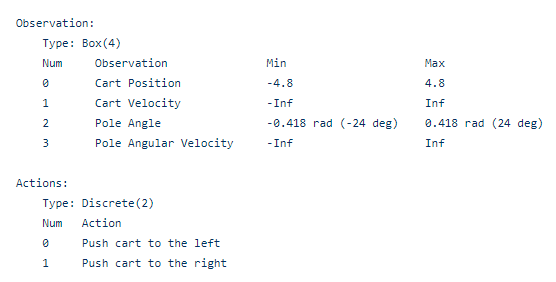

In [8]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [9]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [10]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [11]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [12]:
def CartPoleShowResults(score_list, exploration, dist=5, interp=False, top_line=True):
    
    if interp: fit_res = np.polyfit(np.arange(len(score_list)), score_list, 1)
    game_solved=None
    score_runn_avg_pole=[]
    for i in range(dist,len(score_list)-dist):
        score_runn_avg_pole.append(np.mean(score_list[i-dist:i+dist]))

    __, (ax_score, ax_expl) = plt.subplots(1,2,figsize=(15,5))
    ax_score.plot(score_list, "o-", markersize=3, lw=0.5, label="scores")
    ax_score.plot(np.arange(dist, len(score_list)-dist),score_runn_avg_pole, label="runnig avg.")
    if top_line: ax_score.hlines(500, 0,len(score_list),linestyles="--", color="r")
    if 500 in score_list:
        game_solved=np.where(np.array(score_list)==500)[0][0]
        ax_score.vlines(game_solved,0,500, linestyles="-", color="gold", lw=3)
    
    if interp: ax_score.plot(np.arange(len(score_list)), np.arange(len(score_list))*fit_res[0]+fit_res[1], label="linear trend")
    
    ax_score.set_xlabel("Nr of iterations")
    ax_score.set_ylabel("Score")
    ax_score.grid(axis="x")
    ax_score.set_title('Score', fontweight='bold')
    ax_score.legend()

    ax_expl.plot(exploration, color="forestgreen")
    ax_expl.grid()
    ax_expl.set_xlabel('Iteration')
    #ax_expl.set_ylabel('Exploration profile')
    ax_expl.set_title('Exploration profile', fontweight='bold')

    plt.tight_layout()
    plt.show()

    if game_solved!=None:
        print("Game solved at iteration nr %d" %(game_solved))



## Training loop

In [13]:
def TrainingLoopAdvanced(initial_value=5,
                         num_iterations=600,
                         stepness=6,
                         policy="softmax",
                         gamma = 0.97,
                         replay_memory_capacity = 10000,
                         lr = 1e-2, 
                         target_net_update_steps = 10, 
                         batch_size = 128,
                         bad_state_penalty = 0, 
                         pos_weight=2,
                         ang_weight=5,
                         min_samples_for_training = 1000,
                         checkpoint="",
                         printt=True, 
                         env_show=True):


    ### Exploration profile definition
    if policy=="greedy":
        if initial_value>1:
            initial_value=0.5

    exploration_profile = exp_exploration(initial_value=initial_value, num_iterations=num_iterations, stepness=stepness)

    ### Setting up the enviroment
    env = gym.make('CartPole-v1') 
    env.seed(0)

    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)
    if checkpoint!="":
        policy_net.load_state_dict(torch.load(checkpoint))

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)

    score_list=[]

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            if policy=="softmax":
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            elif policy=="greedy":
                if initial_value>1:
                    initial_value=0.5
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            reward = reward - pos_weight * np.abs(state[0]) 

            reward = reward - ang_weight * np.abs(state[2]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            if env_show: 
                env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            if printt: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if printt: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}- reward {q_values}") # Print the final score
        score_list.append(score)

    env.close()

    return policy_net, target_net, score_list, exploration_profile

### Different rewards

#### None

In [14]:
np.random.seed(0)
torch.manual_seed(10)

policy_net_none, target_net_none, score_list_none, exploration_profile_none = TrainingLoopAdvanced(initial_value=5, 
                                                                               num_iterations=600, 
                                                                               stepness=6,
                                                                               ang_weight=0,
                                                                               pos_weight=0,
                                                                               bad_state_penalty=0, 
                                                                               printt=False, 
                                                                               env_show=False)

  0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_37149/4057174605.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/torch/csrc/utils/tensor_new.cpp:201.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)


KeyboardInterrupt: 

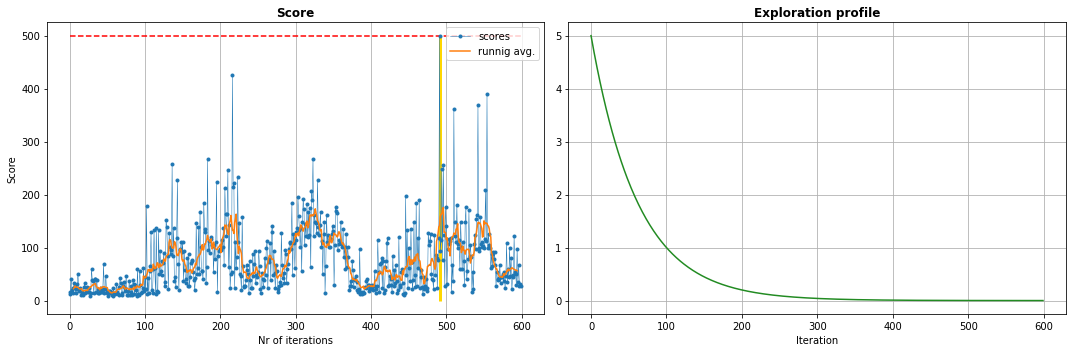

Game solved at iteration nr 491
Avarage score: 74.345
Number of succesflu games: 1


In [16]:
CartPoleShowResults(score_list_none, exploration_profile_none, dist=5)
print("Avarage score: %.3f" %(np.mean(score_list_none)))
print("Number of succesflu games: %d" %(len(np.where(np.array(score_list_none)==500)[0])))

#### Position weight

In [17]:
np.random.seed(0)
torch.manual_seed(10)

policy_net_pos, target_net_pos, score_list_pos, exploration_profile_pos = TrainingLoopAdvanced(initial_value=4, 
                                                                               num_iterations=600, 
                                                                               stepness=6,
                                                                               ang_weight=0,
                                                                               pos_weight=5,
                                                                               bad_state_penalty=0, 
                                                                               printt=False, 
                                                                               env_show=False)

  0%|          | 0/600 [00:00<?, ?it/s]

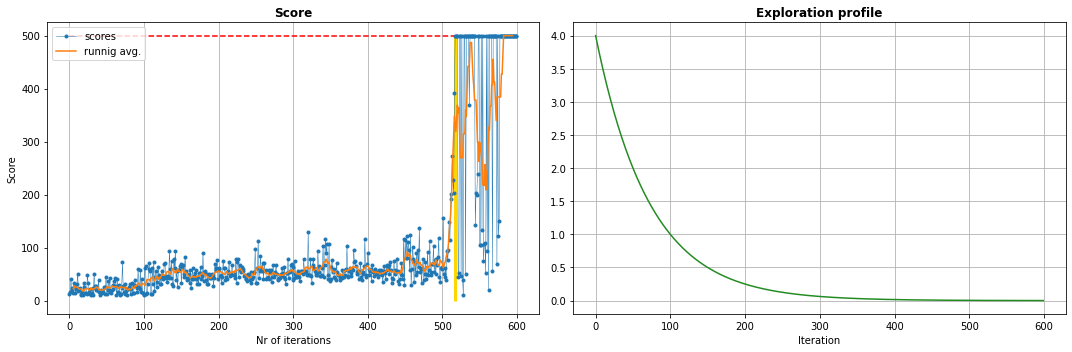

Game solved at iteration nr 517
Avarage score: 98.572
Number of succesflu games: 59


In [18]:
CartPoleShowResults(score_list_pos, exploration_profile_pos, dist=5)
print("Avarage score: %.3f" %(np.mean(score_list_pos)))
print("Number of succesflu games: %d" %(len(np.where(np.array(score_list_pos)==500)[0])))

#### Angualr weight

In [52]:
np.random.seed(0)
torch.manual_seed(10)

policy_net_ang, target_net_ang, score_list_ang, exploration_profile_ang = TrainingLoopAdvanced(initial_value=4, 
                                                                               num_iterations=600, 
                                                                               stepness=6,
                                                                               ang_weight=10,
                                                                               pos_weight=0,
                                                                               bad_state_penalty=0, 
                                                                               printt=False, 
                                                                               env_show=False)

  0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_30148/4057174605.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/torch/csrc/utils/tensor_new.cpp:201.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)


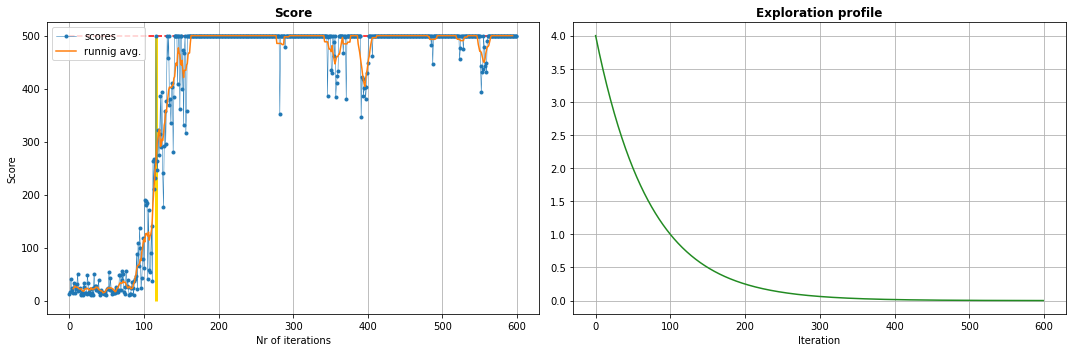

Game solved at iteration nr 116
Avarage score: 400.023
Number of succesflu games: 413


In [53]:
CartPoleShowResults(score_list_ang, exploration_profile_ang, dist=5)
print("Avarage score: %.3f" %(np.mean(score_list_ang)))
print("Number of succesflu games: %d" %(len(np.where(np.array(score_list_ang)==500)[0])))

In [54]:
torch.save(policy_net_ang.state_dict(), "policy_net_ang.pth")

#### Bad state penalty

In [21]:
np.random.seed(0)
torch.manual_seed(10)

policy_net_bad, target_net_bad, score_list_bad, exploration_profile_bad = TrainingLoopAdvanced(initial_value=4, 
                                                                               num_iterations=600, 
                                                                               stepness=6,
                                                                               ang_weight=0,
                                                                               pos_weight=0,
                                                                               bad_state_penalty=10, 
                                                                               printt=False, 
                                                                               env_show=False)

  0%|          | 0/600 [00:00<?, ?it/s]

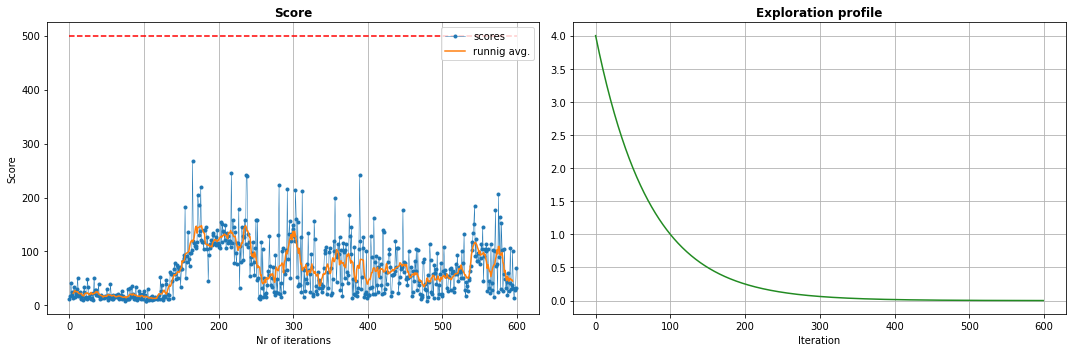

Avarage score: 65.755
Number of succesflu games: 0


In [22]:
CartPoleShowResults(score_list_bad, exploration_profile_bad, dist=5)
print("Avarage score: %.3f" %(np.mean(score_list_bad)))
print("Number of succesflu games: %d" %(len(np.where(np.array(score_list_bad)==500)[0])))

### Exploration profiles

#### High exploration SOFTMAX

In [23]:
np.random.seed(0)
torch.manual_seed(5)

policy_net_S_Hexp, target_net_S_Hexp, score_list_S_Hexp, exploration_profile_S_Hexp = TrainingLoopAdvanced(initial_value=4, 
                                                                               num_iterations=600, 
                                                                               stepness=1.5,
                                                                               ang_weight=2,
                                                                               pos_weight=1,
                                                                               printt=False, 
                                                                               env_show=False)

  0%|          | 0/600 [00:00<?, ?it/s]

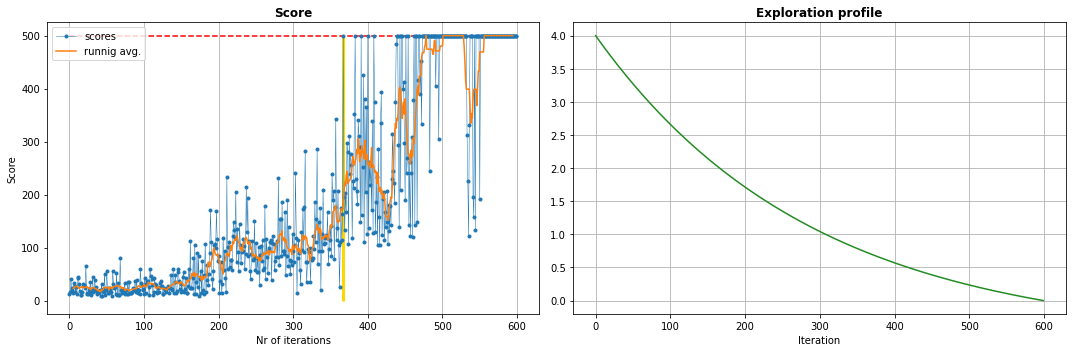

Game solved at iteration nr 367
Avarage score: 190.540
Number of succesflu games: 133


In [24]:
CartPoleShowResults(score_list_S_Hexp, exploration_profile_S_Hexp, dist=5)
print("Avarage score: %.3f" %(np.mean(score_list_S_Hexp)))
print("Number of succesflu games: %d" %(len(np.where(np.array(score_list_S_Hexp)==500)[0])))

#### High exploitation SOFTMAX

In [25]:
np.random.seed(0)
torch.manual_seed(10)

policy_net_S_Lexp, target_net_S_Lexp, score_list_S_Lexp, exploration_profile_S_Lexp = TrainingLoopAdvanced(initial_value=4, 
                                                                               num_iterations=600, 
                                                                               stepness=10, 
                                                                               ang_weight=2,
                                                                               pos_weight=1,
                                                                               printt=False, 
                                                                               env_show=False)

  0%|          | 0/600 [00:00<?, ?it/s]

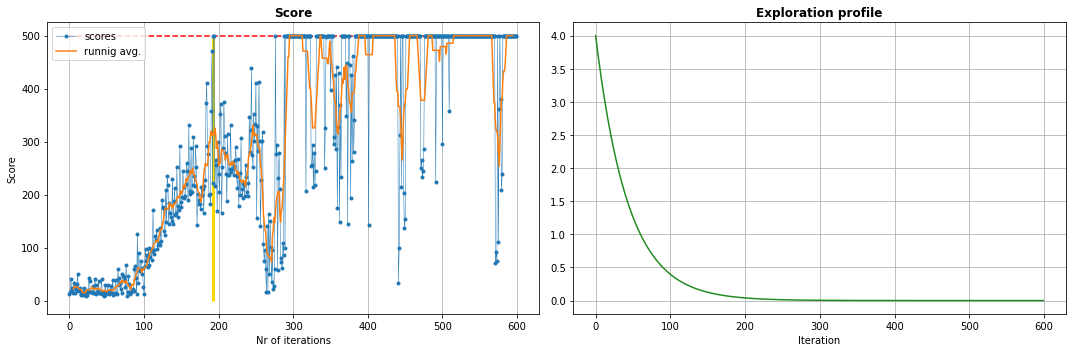

Game solved at iteration nr 193
Avarage score: 306.672
Number of succesful games: 257


In [26]:
CartPoleShowResults(score_list_S_Lexp, exploration_profile_S_Lexp, dist=5)
print("Avarage score: %.3f" %(np.mean(score_list_S_Lexp)))
print("Number of succesful games: %d" %(len(np.where(np.array(score_list_S_Lexp)==500)[0])))

#### High exploration EPSILON-GREEDY

In [27]:
np.random.seed(0)
torch.manual_seed(10)

policy_net_Gr_Hexp, target_net_Gr_Hexp, score_list_Gr_Hexp, exploration_profile_Gr_Hexp = TrainingLoopAdvanced(initial_value=0.4, 
                                                                               num_iterations=600,
                                                                               policy="greedy", 
                                                                               stepness=1.5, 
                                                                               ang_weight=2,
                                                                               pos_weight=1,
                                                                               printt=False, 
                                                                               env_show=False)

  0%|          | 0/600 [00:00<?, ?it/s]

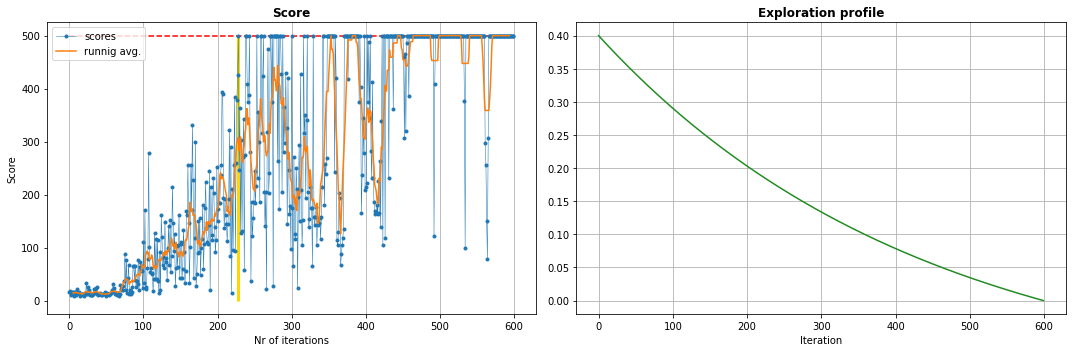

Game solved at iteration nr 228
Avarage score: 273.943
Number of succesful games: 219


In [28]:
CartPoleShowResults(score_list_Gr_Hexp, exploration_profile_Gr_Hexp, dist=5)
print("Avarage score: %.3f" %(np.mean(score_list_Gr_Hexp)))
print("Number of succesful games: %d" %(len(np.where(np.array(score_list_Gr_Hexp)==500)[0])))

#### High exploitation EPSILON-GREEDY

In [29]:
np.random.seed(0)
torch.manual_seed(10)

policy_net_Gr_Lexp, target_net_Gr_Lexp, score_list_Gr_Lexp, exploration_profile_Gr_Lexp = TrainingLoopAdvanced(initial_value=0.4, 
                                                                               num_iterations=600,
                                                                               policy="greedy", 
                                                                               stepness=10, 
                                                                               ang_weight=2,
                                                                               pos_weight=1,
                                                                               printt=False, 
                                                                               env_show=False)

  0%|          | 0/600 [00:00<?, ?it/s]

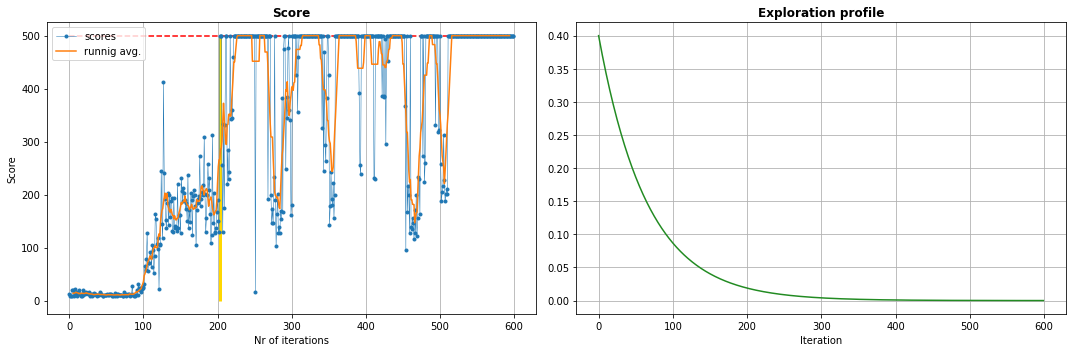

Game solved at iteration nr 203
Avarage score: 316.610
Number of succesful games: 293


In [30]:
CartPoleShowResults(score_list_Gr_Lexp, exploration_profile_Gr_Lexp, dist=5)
print("Avarage score: %.3f" %(np.mean(score_list_Gr_Lexp)))
print("Number of succesful games: %d" %(len(np.where(np.array(score_list_Gr_Lexp)==500)[0])))

### Score variabilty

In [31]:
limit=150
print("Standard deviation Softmax high exploration: %.3f" %(np.std(score_list_S_Hexp[-limit:-1])))
print("Standard deviation Softmax high exploitation: %.3f" %(np.std(score_list_S_Lexp[-limit:-1])))
print("Standard deviation Eps_Gr. high exploration: %.3f" %(np.std(score_list_Gr_Hexp[-limit:-1])))
print("Standard deviation Eps_Gr. high exploitation: %.3f" %(np.std(score_list_Gr_Lexp[-limit:-1])))

Standard deviation Softmax high exploration: 104.910
Standard deviation Softmax high exploitation: 92.864
Standard deviation Eps_Gr. high exploration: 72.915
Standard deviation Eps_Gr. high exploitation: 128.862


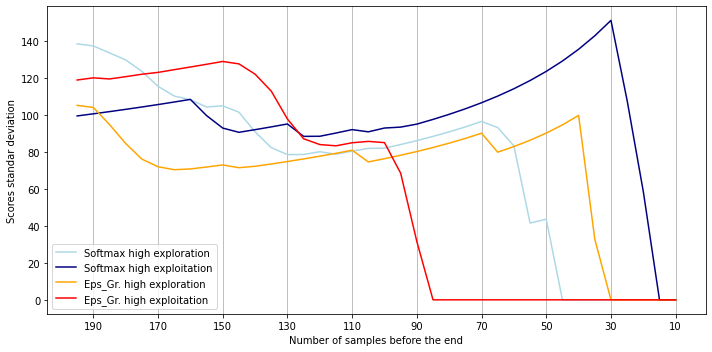

In [32]:
limits=np.arange(10,200,5)
std_list=[]
for l in limits:
    std_list.append([np.std(score_list_S_Hexp[-l:-1]), 
                     np.std(score_list_S_Lexp[-l:-1]), 
                     np.std(score_list_Gr_Hexp[-l:-1]), 
                     np.std(score_list_Gr_Lexp[-l:-1])])
std_list=np.array(std_list)

__, ax_std = plt.subplots(1,1,figsize=(10,5))
std_labels=["Softmax high exploration", "Softmax high exploitation", "Eps_Gr. high exploration", "Eps_Gr. high exploitation"]
std_colors=["lightblue", "navy", "orange", "r"]
for i in range(4):
    ax_std.plot(limits, std_list[:,i], label=std_labels[i], color=std_colors[i])
ax_std.legend()
ax_std.invert_xaxis()
ax_std.set_xticks(limits[::4])
ax_std.set_xlabel("Number of samples before the end")
ax_std.set_ylabel("Scores standar deviation")
ax_std.grid(axis="x")
plt.tight_layout()


## Hyperparamters search

In [33]:
def objective(trial):

    hyperparameters = [
        trial.suggest_int("initial_value", 2,20),
        trial.suggest_int("stepness", 1,10),
        trial.suggest_float("lr", 1e-5, 1e-1, log=True),
        trial.suggest_int("target_net_update_steps", 5, 30),
        trial.suggest_categorical("bad_state_penalty", [0,1,10,100]),
        trial.suggest_int("pos_weight", 0,15),
        trial.suggest_int("ang_weight", 0,15),
        trial.suggest_categorical("policy", ["softmax", "greedy"])
    ]

    if hyperparameters[7]=="greedy":
        hyperparameters[0]=hyperparameters[0]/40

    policy_net, target_net, score_list, expl = TrainingLoopAdvanced(initial_value=hyperparameters[0],
                                                            num_iterations=600,
                                                            stepness=hyperparameters[1],
                                                            gamma = 0.97,
                                                            replay_memory_capacity = 10000,
                                                            lr = hyperparameters[2], 
                                                            target_net_update_steps = hyperparameters[3], 
                                                            batch_size = 128,
                                                            bad_state_penalty = hyperparameters[4], 
                                                            pos_weight=hyperparameters[5],
                                                            ang_weight=hyperparameters[6],
                                                            min_samples_for_training = 1000,
                                                            printt=False,
                                                            env_show=False)
    game_solved=10000
    if 500 in score_list:
        game_solved=np.where(np.array(score_list)==500)[0][0]
    print(game_solved)
    return game_solved

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler=RandomSampler(seed=10)
study = optuna.create_study(study_name="CartPoleOpt_Speed", direction="minimize", pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Validation loss: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-31 23:53:42,284] A new study created in memory with name: CartPoleOpt_Speed


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-01-31 23:53:51,398] Trial 0 finished with value: 10000.0 and parameters: {'initial_value': 16, 'stepness': 1, 'lr': 0.0034244666391252923, 'target_net_update_steps': 24, 'bad_state_penalty': 100, 'pos_weight': 2, 'ang_weight': 1, 'policy': 'greedy'}. Best is trial 0 with value: 10000.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-01-31 23:54:21,124] Trial 1 finished with value: 10000.0 and parameters: {'initial_value': 2, 'stepness': 6, 'lr': 0.017802616915745105, 'target_net_update_steps': 20, 'bad_state_penalty': 10, 'pos_weight': 8, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 0 with value: 10000.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-01-31 23:54:51,651] Trial 2 finished with value: 10000.0 and parameters: {'initial_value': 10, 'stepness': 5, 'lr': 0.002958475069260415, 'target_net_update_steps': 18, 'bad_state_penalty': 10, 'pos_weight': 14, 'ang_weight': 5, 'policy': 'greedy'}. Best is trial 0 with value: 10000.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-01-31 23:55:02,222] Trial 3 finished with value: 10000.0 and parameters: {'initial_value': 4, 'stepness': 9, 'lr': 1.54022893392202e-05, 'target_net_update_steps': 21, 'bad_state_penalty': 100, 'pos_weight': 5, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 0 with value: 10000.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-01-31 23:55:13,607] Trial 4 finished with value: 10000.0 and parameters: {'initial_value': 8, 'stepness': 2, 'lr': 0.0003716353143639785, 'target_net_update_steps': 7, 'bad_state_penalty': 100, 'pos_weight': 15, 'ang_weight': 7, 'policy': 'softmax'}. Best is trial 0 with value: 10000.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-01-31 23:57:49,532] Trial 5 finished with value: 175.0 and parameters: {'initial_value': 13, 'stepness': 10, 'lr': 0.0013747755356908551, 'target_net_update_steps': 20, 'bad_state_penalty': 1, 'pos_weight': 5, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 5 with value: 175.0.


175


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:01:56,028] Trial 6 finished with value: 229.0 and parameters: {'initial_value': 7, 'stepness': 7, 'lr': 0.00024287823618459413, 'target_net_update_steps': 6, 'bad_state_penalty': 0, 'pos_weight': 9, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 5 with value: 175.0.


229


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:06:49,836] Trial 7 finished with value: 187.0 and parameters: {'initial_value': 7, 'stepness': 1, 'lr': 0.00016302351115057964, 'target_net_update_steps': 11, 'bad_state_penalty': 1, 'pos_weight': 1, 'ang_weight': 15, 'policy': 'greedy'}. Best is trial 5 with value: 175.0.


187


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:08:31,322] Trial 8 finished with value: 399.0 and parameters: {'initial_value': 20, 'stepness': 5, 'lr': 0.00018753883849476243, 'target_net_update_steps': 18, 'bad_state_penalty': 1, 'pos_weight': 12, 'ang_weight': 11, 'policy': 'softmax'}. Best is trial 5 with value: 175.0.


399


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:12:03,024] Trial 9 finished with value: 348.0 and parameters: {'initial_value': 8, 'stepness': 6, 'lr': 0.0001580954931799219, 'target_net_update_steps': 18, 'bad_state_penalty': 0, 'pos_weight': 1, 'ang_weight': 2, 'policy': 'softmax'}. Best is trial 5 with value: 175.0.


348


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:12:34,426] Trial 10 finished with value: 496.0 and parameters: {'initial_value': 6, 'stepness': 8, 'lr': 2.6761985901551282e-05, 'target_net_update_steps': 24, 'bad_state_penalty': 1, 'pos_weight': 10, 'ang_weight': 0, 'policy': 'greedy'}. Best is trial 5 with value: 175.0.


496


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:12:59,984] Trial 11 finished with value: 10000.0 and parameters: {'initial_value': 6, 'stepness': 4, 'lr': 0.04885748952825859, 'target_net_update_steps': 29, 'bad_state_penalty': 100, 'pos_weight': 9, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 5 with value: 175.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:14:14,021] Trial 12 finished with value: 195.0 and parameters: {'initial_value': 13, 'stepness': 8, 'lr': 3.92765927305423e-05, 'target_net_update_steps': 16, 'bad_state_penalty': 0, 'pos_weight': 8, 'ang_weight': 13, 'policy': 'greedy'}. Best is trial 5 with value: 175.0.


195


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:14:53,558] Trial 13 finished with value: 404.0 and parameters: {'initial_value': 12, 'stepness': 6, 'lr': 6.20015617266931e-05, 'target_net_update_steps': 16, 'bad_state_penalty': 100, 'pos_weight': 11, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 5 with value: 175.0.


404


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:15:24,512] Trial 14 finished with value: 10000.0 and parameters: {'initial_value': 17, 'stepness': 6, 'lr': 0.01351634514067736, 'target_net_update_steps': 27, 'bad_state_penalty': 1, 'pos_weight': 12, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 5 with value: 175.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:20:22,748] Trial 15 finished with value: 147.0 and parameters: {'initial_value': 11, 'stepness': 9, 'lr': 5.003288884344242e-05, 'target_net_update_steps': 5, 'bad_state_penalty': 0, 'pos_weight': 1, 'ang_weight': 5, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


147


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:22:25,515] Trial 16 finished with value: 272.0 and parameters: {'initial_value': 3, 'stepness': 3, 'lr': 0.0019728993321901935, 'target_net_update_steps': 12, 'bad_state_penalty': 1, 'pos_weight': 13, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


272


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:22:40,048] Trial 17 finished with value: 10000.0 and parameters: {'initial_value': 9, 'stepness': 3, 'lr': 0.020778188377171367, 'target_net_update_steps': 24, 'bad_state_penalty': 100, 'pos_weight': 15, 'ang_weight': 5, 'policy': 'softmax'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:22:46,784] Trial 18 finished with value: 10000.0 and parameters: {'initial_value': 2, 'stepness': 1, 'lr': 5.4765537199717634e-05, 'target_net_update_steps': 6, 'bad_state_penalty': 1, 'pos_weight': 12, 'ang_weight': 6, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:23:57,742] Trial 19 finished with value: 343.0 and parameters: {'initial_value': 7, 'stepness': 8, 'lr': 0.0002649045216318843, 'target_net_update_steps': 25, 'bad_state_penalty': 0, 'pos_weight': 6, 'ang_weight': 6, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


343


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:24:28,876] Trial 20 finished with value: 10000.0 and parameters: {'initial_value': 7, 'stepness': 4, 'lr': 0.014896798113898359, 'target_net_update_steps': 15, 'bad_state_penalty': 1, 'pos_weight': 15, 'ang_weight': 3, 'policy': 'softmax'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:26:27,764] Trial 21 finished with value: 211.0 and parameters: {'initial_value': 17, 'stepness': 7, 'lr': 0.01926929851629218, 'target_net_update_steps': 12, 'bad_state_penalty': 10, 'pos_weight': 4, 'ang_weight': 1, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


211


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:26:44,050] Trial 22 finished with value: 10000.0 and parameters: {'initial_value': 14, 'stepness': 2, 'lr': 1.538002029847757e-05, 'target_net_update_steps': 29, 'bad_state_penalty': 10, 'pos_weight': 14, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:26:52,609] Trial 23 finished with value: 10000.0 and parameters: {'initial_value': 16, 'stepness': 4, 'lr': 0.003565663253617687, 'target_net_update_steps': 5, 'bad_state_penalty': 100, 'pos_weight': 6, 'ang_weight': 6, 'policy': 'softmax'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:27:20,607] Trial 24 finished with value: 10000.0 and parameters: {'initial_value': 9, 'stepness': 2, 'lr': 2.2278073667148834e-05, 'target_net_update_steps': 25, 'bad_state_penalty': 100, 'pos_weight': 9, 'ang_weight': 10, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:29:24,626] Trial 25 finished with value: 193.0 and parameters: {'initial_value': 15, 'stepness': 2, 'lr': 0.016294091353353274, 'target_net_update_steps': 18, 'bad_state_penalty': 0, 'pos_weight': 8, 'ang_weight': 11, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


193


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:29:56,410] Trial 26 finished with value: 10000.0 and parameters: {'initial_value': 17, 'stepness': 1, 'lr': 0.07135592213036802, 'target_net_update_steps': 30, 'bad_state_penalty': 0, 'pos_weight': 12, 'ang_weight': 3, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:30:29,601] Trial 27 finished with value: 10000.0 and parameters: {'initial_value': 3, 'stepness': 3, 'lr': 0.0010998339923223817, 'target_net_update_steps': 30, 'bad_state_penalty': 10, 'pos_weight': 4, 'ang_weight': 11, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:30:41,039] Trial 28 finished with value: 10000.0 and parameters: {'initial_value': 13, 'stepness': 2, 'lr': 0.002897400083061456, 'target_net_update_steps': 28, 'bad_state_penalty': 100, 'pos_weight': 6, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:35:07,237] Trial 29 finished with value: 169.0 and parameters: {'initial_value': 14, 'stepness': 10, 'lr': 0.002824338380062246, 'target_net_update_steps': 26, 'bad_state_penalty': 1, 'pos_weight': 2, 'ang_weight': 14, 'policy': 'softmax'}. Best is trial 15 with value: 147.0.


169


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:36:24,623] Trial 30 finished with value: 455.0 and parameters: {'initial_value': 3, 'stepness': 2, 'lr': 0.012141854415086754, 'target_net_update_steps': 24, 'bad_state_penalty': 10, 'pos_weight': 8, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


455


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:36:58,581] Trial 31 finished with value: 10000.0 and parameters: {'initial_value': 11, 'stepness': 6, 'lr': 0.0005793596293841241, 'target_net_update_steps': 23, 'bad_state_penalty': 1, 'pos_weight': 7, 'ang_weight': 1, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:37:06,251] Trial 32 finished with value: 10000.0 and parameters: {'initial_value': 15, 'stepness': 4, 'lr': 1.8681908658321992e-05, 'target_net_update_steps': 5, 'bad_state_penalty': 0, 'pos_weight': 0, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:39:18,329] Trial 33 finished with value: 194.0 and parameters: {'initial_value': 8, 'stepness': 9, 'lr': 0.0004456045678191617, 'target_net_update_steps': 11, 'bad_state_penalty': 1, 'pos_weight': 13, 'ang_weight': 8, 'policy': 'greedy'}. Best is trial 15 with value: 147.0.


194


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:39:47,991] Trial 34 finished with value: 121.0 and parameters: {'initial_value': 14, 'stepness': 8, 'lr': 0.03707471376705723, 'target_net_update_steps': 13, 'bad_state_penalty': 100, 'pos_weight': 6, 'ang_weight': 13, 'policy': 'softmax'}. Best is trial 34 with value: 121.0.


121


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:40:23,504] Trial 35 finished with value: 577.0 and parameters: {'initial_value': 3, 'stepness': 1, 'lr': 4.975076608132611e-05, 'target_net_update_steps': 16, 'bad_state_penalty': 1, 'pos_weight': 10, 'ang_weight': 10, 'policy': 'greedy'}. Best is trial 34 with value: 121.0.


577


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:40:34,261] Trial 36 finished with value: 10000.0 and parameters: {'initial_value': 17, 'stepness': 10, 'lr': 0.0028558836273006394, 'target_net_update_steps': 30, 'bad_state_penalty': 100, 'pos_weight': 7, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 34 with value: 121.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:41:49,961] Trial 37 finished with value: 301.0 and parameters: {'initial_value': 14, 'stepness': 6, 'lr': 0.0001388547794355556, 'target_net_update_steps': 21, 'bad_state_penalty': 100, 'pos_weight': 1, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 34 with value: 121.0.


301


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:41:59,523] Trial 38 finished with value: 10000.0 and parameters: {'initial_value': 2, 'stepness': 10, 'lr': 0.017039864346985588, 'target_net_update_steps': 12, 'bad_state_penalty': 100, 'pos_weight': 14, 'ang_weight': 3, 'policy': 'greedy'}. Best is trial 34 with value: 121.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:42:21,139] Trial 39 finished with value: 10000.0 and parameters: {'initial_value': 7, 'stepness': 10, 'lr': 0.011913753992492481, 'target_net_update_steps': 28, 'bad_state_penalty': 100, 'pos_weight': 13, 'ang_weight': 11, 'policy': 'greedy'}. Best is trial 34 with value: 121.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:43:34,605] Trial 40 finished with value: 533.0 and parameters: {'initial_value': 6, 'stepness': 1, 'lr': 5.99670517217947e-05, 'target_net_update_steps': 21, 'bad_state_penalty': 0, 'pos_weight': 8, 'ang_weight': 12, 'policy': 'softmax'}. Best is trial 34 with value: 121.0.


533


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:44:01,358] Trial 41 finished with value: 10000.0 and parameters: {'initial_value': 2, 'stepness': 8, 'lr': 1.422897501366605e-05, 'target_net_update_steps': 16, 'bad_state_penalty': 0, 'pos_weight': 0, 'ang_weight': 0, 'policy': 'softmax'}. Best is trial 34 with value: 121.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:49:33,199] Trial 42 finished with value: 116.0 and parameters: {'initial_value': 13, 'stepness': 9, 'lr': 0.00044517944268887723, 'target_net_update_steps': 5, 'bad_state_penalty': 10, 'pos_weight': 0, 'ang_weight': 13, 'policy': 'softmax'}. Best is trial 42 with value: 116.0.


116


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:51:40,016] Trial 43 finished with value: 348.0 and parameters: {'initial_value': 7, 'stepness': 9, 'lr': 0.0029388553582380007, 'target_net_update_steps': 8, 'bad_state_penalty': 10, 'pos_weight': 12, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 42 with value: 116.0.


348


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:52:11,514] Trial 44 finished with value: 10000.0 and parameters: {'initial_value': 14, 'stepness': 1, 'lr': 1.255900211750423e-05, 'target_net_update_steps': 22, 'bad_state_penalty': 1, 'pos_weight': 9, 'ang_weight': 4, 'policy': 'greedy'}. Best is trial 42 with value: 116.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:52:18,248] Trial 45 finished with value: 10000.0 and parameters: {'initial_value': 5, 'stepness': 4, 'lr': 2.6064911846142626e-05, 'target_net_update_steps': 15, 'bad_state_penalty': 10, 'pos_weight': 1, 'ang_weight': 0, 'policy': 'greedy'}. Best is trial 42 with value: 116.0.


10000


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:56:20,938] Trial 46 finished with value: 131.0 and parameters: {'initial_value': 11, 'stepness': 2, 'lr': 0.05412442110508124, 'target_net_update_steps': 22, 'bad_state_penalty': 0, 'pos_weight': 1, 'ang_weight': 14, 'policy': 'greedy'}. Best is trial 42 with value: 116.0.


131


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 00:56:37,879] Trial 47 finished with value: 280.0 and parameters: {'initial_value': 4, 'stepness': 10, 'lr': 0.0001628241219900613, 'target_net_update_steps': 10, 'bad_state_penalty': 100, 'pos_weight': 10, 'ang_weight': 4, 'policy': 'greedy'}. Best is trial 42 with value: 116.0.


280


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:01:29,800] Trial 48 finished with value: 130.0 and parameters: {'initial_value': 18, 'stepness': 7, 'lr': 0.010422451902763537, 'target_net_update_steps': 16, 'bad_state_penalty': 1, 'pos_weight': 1, 'ang_weight': 9, 'policy': 'greedy'}. Best is trial 42 with value: 116.0.


130


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:03:29,957] Trial 49 finished with value: 186.0 and parameters: {'initial_value': 7, 'stepness': 8, 'lr': 8.043416395915822e-05, 'target_net_update_steps': 5, 'bad_state_penalty': 100, 'pos_weight': 3, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 42 with value: 116.0.


186
Number of finished trials: 50
Best trial:
  Validation loss: 116.0
  Params: 
    initial_value: 13
    stepness: 9
    lr: 0.00044517944268887723
    target_net_update_steps: 5
    bad_state_penalty: 10
    pos_weight: 0
    ang_weight: 13
    policy: softmax


In [34]:
def objective(trial):

    hyperparameters = [
        trial.suggest_int("initial_value", 2,20),
        trial.suggest_int("stepness", 1,10),
        trial.suggest_float("lr", 1e-5, 1e-1, log=True),
        trial.suggest_int("target_net_update_steps", 5, 30),
        trial.suggest_categorical("bad_state_penalty", [0,1,10,100]),
        trial.suggest_int("pos_weight", 0,15),
        trial.suggest_int("ang_weight", 0,15),
        trial.suggest_categorical("policy", ["softmax", "greedy"])
    ]

    if hyperparameters[7]=="greedy":
        hyperparameters[0]=hyperparameters[0]/40

    policy_net, target_net, score_list, expl = TrainingLoopAdvanced(initial_value=hyperparameters[0],
                                                            num_iterations=600,
                                                            stepness=hyperparameters[1],
                                                            gamma = 0.97,
                                                            replay_memory_capacity = 10000,
                                                            lr = hyperparameters[2], 
                                                            target_net_update_steps = hyperparameters[3], 
                                                            batch_size = 128,
                                                            bad_state_penalty = hyperparameters[4], 
                                                            pos_weight=hyperparameters[5],
                                                            ang_weight=hyperparameters[6],
                                                            min_samples_for_training = 1000,
                                                            printt=False,
                                                            env_show=False)
    return np.mean(score_list[-150:-1])

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler=RandomSampler(seed=10)
study = optuna.create_study(study_name="CartPoleOpt_Efficiency", direction="maximize", pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Avarage score: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-01 01:03:30,605] A new study created in memory with name: CartPoleOpt_Efficiency


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:03:39,543] Trial 0 finished with value: 9.389261744966444 and parameters: {'initial_value': 16, 'stepness': 1, 'lr': 0.0034244666391252923, 'target_net_update_steps': 24, 'bad_state_penalty': 100, 'pos_weight': 2, 'ang_weight': 1, 'policy': 'greedy'}. Best is trial 0 with value: 9.389261744966444.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:04:12,648] Trial 1 finished with value: 69.09395973154362 and parameters: {'initial_value': 2, 'stepness': 6, 'lr': 0.017802616915745105, 'target_net_update_steps': 20, 'bad_state_penalty': 10, 'pos_weight': 8, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 1 with value: 69.09395973154362.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:04:42,736] Trial 2 finished with value: 42.22147651006711 and parameters: {'initial_value': 10, 'stepness': 5, 'lr': 0.002958475069260415, 'target_net_update_steps': 18, 'bad_state_penalty': 10, 'pos_weight': 14, 'ang_weight': 5, 'policy': 'greedy'}. Best is trial 1 with value: 69.09395973154362.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:04:51,450] Trial 3 finished with value: 9.765100671140939 and parameters: {'initial_value': 4, 'stepness': 9, 'lr': 1.54022893392202e-05, 'target_net_update_steps': 21, 'bad_state_penalty': 100, 'pos_weight': 5, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 1 with value: 69.09395973154362.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:05:02,784] Trial 4 finished with value: 9.355704697986576 and parameters: {'initial_value': 8, 'stepness': 2, 'lr': 0.0003716353143639785, 'target_net_update_steps': 7, 'bad_state_penalty': 100, 'pos_weight': 15, 'ang_weight': 7, 'policy': 'softmax'}. Best is trial 1 with value: 69.09395973154362.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:08:14,205] Trial 5 finished with value: 196.00671140939596 and parameters: {'initial_value': 13, 'stepness': 10, 'lr': 0.0013747755356908551, 'target_net_update_steps': 20, 'bad_state_penalty': 1, 'pos_weight': 5, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 5 with value: 196.00671140939596.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:11:56,204] Trial 6 finished with value: 484.77852348993287 and parameters: {'initial_value': 7, 'stepness': 7, 'lr': 0.00024287823618459413, 'target_net_update_steps': 6, 'bad_state_penalty': 0, 'pos_weight': 9, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 6 with value: 484.77852348993287.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:17:22,996] Trial 7 finished with value: 500.0 and parameters: {'initial_value': 7, 'stepness': 1, 'lr': 0.00016302351115057964, 'target_net_update_steps': 11, 'bad_state_penalty': 1, 'pos_weight': 1, 'ang_weight': 15, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:19:30,091] Trial 8 finished with value: 414.6577181208054 and parameters: {'initial_value': 20, 'stepness': 5, 'lr': 0.00018753883849476243, 'target_net_update_steps': 18, 'bad_state_penalty': 1, 'pos_weight': 12, 'ang_weight': 11, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:23:10,804] Trial 9 finished with value: 484.38926174496646 and parameters: {'initial_value': 8, 'stepness': 6, 'lr': 0.0001580954931799219, 'target_net_update_steps': 18, 'bad_state_penalty': 0, 'pos_weight': 1, 'ang_weight': 2, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:23:26,267] Trial 10 finished with value: 27.859060402684563 and parameters: {'initial_value': 6, 'stepness': 8, 'lr': 2.6761985901551282e-05, 'target_net_update_steps': 24, 'bad_state_penalty': 1, 'pos_weight': 10, 'ang_weight': 0, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:23:39,624] Trial 11 finished with value: 15.14765100671141 and parameters: {'initial_value': 6, 'stepness': 4, 'lr': 0.04885748952825859, 'target_net_update_steps': 29, 'bad_state_penalty': 100, 'pos_weight': 9, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:23:55,927] Trial 12 finished with value: 42.61744966442953 and parameters: {'initial_value': 13, 'stepness': 8, 'lr': 3.92765927305423e-05, 'target_net_update_steps': 16, 'bad_state_penalty': 0, 'pos_weight': 8, 'ang_weight': 13, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:24:25,937] Trial 13 finished with value: 27.241610738255034 and parameters: {'initial_value': 12, 'stepness': 6, 'lr': 6.20015617266931e-05, 'target_net_update_steps': 16, 'bad_state_penalty': 100, 'pos_weight': 11, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:24:55,459] Trial 14 finished with value: 42.95973154362416 and parameters: {'initial_value': 17, 'stepness': 6, 'lr': 0.01351634514067736, 'target_net_update_steps': 27, 'bad_state_penalty': 1, 'pos_weight': 12, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:28:14,701] Trial 15 finished with value: 497.3691275167785 and parameters: {'initial_value': 11, 'stepness': 9, 'lr': 5.003288884344242e-05, 'target_net_update_steps': 5, 'bad_state_penalty': 0, 'pos_weight': 1, 'ang_weight': 5, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:30:04,758] Trial 16 finished with value: 290.4765100671141 and parameters: {'initial_value': 3, 'stepness': 3, 'lr': 0.0019728993321901935, 'target_net_update_steps': 12, 'bad_state_penalty': 1, 'pos_weight': 13, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:30:17,974] Trial 17 finished with value: 9.845637583892618 and parameters: {'initial_value': 9, 'stepness': 3, 'lr': 0.020778188377171367, 'target_net_update_steps': 24, 'bad_state_penalty': 100, 'pos_weight': 15, 'ang_weight': 5, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:30:52,599] Trial 18 finished with value: 99.16107382550335 and parameters: {'initial_value': 2, 'stepness': 1, 'lr': 5.4765537199717634e-05, 'target_net_update_steps': 6, 'bad_state_penalty': 1, 'pos_weight': 12, 'ang_weight': 6, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:32:56,328] Trial 19 finished with value: 193.53691275167785 and parameters: {'initial_value': 7, 'stepness': 8, 'lr': 0.0002649045216318843, 'target_net_update_steps': 25, 'bad_state_penalty': 0, 'pos_weight': 6, 'ang_weight': 6, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:33:26,254] Trial 20 finished with value: 45.738255033557046 and parameters: {'initial_value': 7, 'stepness': 4, 'lr': 0.014896798113898359, 'target_net_update_steps': 15, 'bad_state_penalty': 1, 'pos_weight': 15, 'ang_weight': 3, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:34:39,589] Trial 21 finished with value: 230.53020134228188 and parameters: {'initial_value': 17, 'stepness': 7, 'lr': 0.01926929851629218, 'target_net_update_steps': 12, 'bad_state_penalty': 10, 'pos_weight': 4, 'ang_weight': 1, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:35:05,829] Trial 22 finished with value: 31.328859060402685 and parameters: {'initial_value': 14, 'stepness': 2, 'lr': 1.538002029847757e-05, 'target_net_update_steps': 29, 'bad_state_penalty': 10, 'pos_weight': 14, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:35:14,357] Trial 23 finished with value: 9.36241610738255 and parameters: {'initial_value': 16, 'stepness': 4, 'lr': 0.003565663253617687, 'target_net_update_steps': 5, 'bad_state_penalty': 100, 'pos_weight': 6, 'ang_weight': 6, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:36:37,626] Trial 24 finished with value: 258.1006711409396 and parameters: {'initial_value': 9, 'stepness': 2, 'lr': 2.2278073667148834e-05, 'target_net_update_steps': 25, 'bad_state_penalty': 100, 'pos_weight': 9, 'ang_weight': 10, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:38:37,183] Trial 25 finished with value: 227.6778523489933 and parameters: {'initial_value': 15, 'stepness': 2, 'lr': 0.016294091353353274, 'target_net_update_steps': 18, 'bad_state_penalty': 0, 'pos_weight': 8, 'ang_weight': 11, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:39:07,675] Trial 26 finished with value: 37.691275167785236 and parameters: {'initial_value': 17, 'stepness': 1, 'lr': 0.07135592213036802, 'target_net_update_steps': 30, 'bad_state_penalty': 0, 'pos_weight': 12, 'ang_weight': 3, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:40:42,132] Trial 27 finished with value: 197.69127516778522 and parameters: {'initial_value': 3, 'stepness': 3, 'lr': 0.0010998339923223817, 'target_net_update_steps': 30, 'bad_state_penalty': 10, 'pos_weight': 4, 'ang_weight': 11, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:40:53,800] Trial 28 finished with value: 9.355704697986576 and parameters: {'initial_value': 13, 'stepness': 2, 'lr': 0.002897400083061456, 'target_net_update_steps': 28, 'bad_state_penalty': 100, 'pos_weight': 6, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:45:41,361] Trial 29 finished with value: 463.0134228187919 and parameters: {'initial_value': 14, 'stepness': 10, 'lr': 0.002824338380062246, 'target_net_update_steps': 26, 'bad_state_penalty': 1, 'pos_weight': 2, 'ang_weight': 14, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:47:09,871] Trial 30 finished with value: 284.26174496644296 and parameters: {'initial_value': 3, 'stepness': 2, 'lr': 0.012141854415086754, 'target_net_update_steps': 24, 'bad_state_penalty': 10, 'pos_weight': 8, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:47:44,846] Trial 31 finished with value: 48.758389261744966 and parameters: {'initial_value': 11, 'stepness': 6, 'lr': 0.0005793596293841241, 'target_net_update_steps': 23, 'bad_state_penalty': 1, 'pos_weight': 7, 'ang_weight': 1, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:47:52,150] Trial 32 finished with value: 9.395973154362416 and parameters: {'initial_value': 15, 'stepness': 4, 'lr': 1.8681908658321992e-05, 'target_net_update_steps': 5, 'bad_state_penalty': 0, 'pos_weight': 0, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:50:29,307] Trial 33 finished with value: 419.26174496644296 and parameters: {'initial_value': 8, 'stepness': 9, 'lr': 0.0004456045678191617, 'target_net_update_steps': 11, 'bad_state_penalty': 1, 'pos_weight': 13, 'ang_weight': 8, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:51:18,177] Trial 34 finished with value: 80.70469798657719 and parameters: {'initial_value': 14, 'stepness': 8, 'lr': 0.03707471376705723, 'target_net_update_steps': 13, 'bad_state_penalty': 100, 'pos_weight': 6, 'ang_weight': 13, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:51:27,811] Trial 35 finished with value: 13.838926174496644 and parameters: {'initial_value': 3, 'stepness': 1, 'lr': 4.975076608132611e-05, 'target_net_update_steps': 16, 'bad_state_penalty': 1, 'pos_weight': 10, 'ang_weight': 10, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:51:36,884] Trial 36 finished with value: 9.355704697986576 and parameters: {'initial_value': 17, 'stepness': 10, 'lr': 0.0028558836273006394, 'target_net_update_steps': 30, 'bad_state_penalty': 100, 'pos_weight': 7, 'ang_weight': 2, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:53:04,867] Trial 37 finished with value: 9.389261744966444 and parameters: {'initial_value': 14, 'stepness': 6, 'lr': 0.0001388547794355556, 'target_net_update_steps': 21, 'bad_state_penalty': 100, 'pos_weight': 1, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:53:13,473] Trial 38 finished with value: 11.288590604026846 and parameters: {'initial_value': 2, 'stepness': 10, 'lr': 0.017039864346985588, 'target_net_update_steps': 12, 'bad_state_penalty': 100, 'pos_weight': 14, 'ang_weight': 3, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:53:30,126] Trial 39 finished with value: 9.389261744966444 and parameters: {'initial_value': 7, 'stepness': 10, 'lr': 0.011913753992492481, 'target_net_update_steps': 28, 'bad_state_penalty': 100, 'pos_weight': 13, 'ang_weight': 11, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:54:46,399] Trial 40 finished with value: 213.91946308724832 and parameters: {'initial_value': 6, 'stepness': 1, 'lr': 5.99670517217947e-05, 'target_net_update_steps': 21, 'bad_state_penalty': 0, 'pos_weight': 8, 'ang_weight': 12, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 01:56:04,365] Trial 41 finished with value: 277.61073825503354 and parameters: {'initial_value': 2, 'stepness': 8, 'lr': 1.422897501366605e-05, 'target_net_update_steps': 16, 'bad_state_penalty': 0, 'pos_weight': 0, 'ang_weight': 0, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 02:01:45,251] Trial 42 finished with value: 500.0 and parameters: {'initial_value': 13, 'stepness': 9, 'lr': 0.00044517944268887723, 'target_net_update_steps': 5, 'bad_state_penalty': 10, 'pos_weight': 0, 'ang_weight': 13, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 02:04:18,094] Trial 43 finished with value: 411.20805369127515 and parameters: {'initial_value': 7, 'stepness': 9, 'lr': 0.0029388553582380007, 'target_net_update_steps': 8, 'bad_state_penalty': 10, 'pos_weight': 12, 'ang_weight': 8, 'policy': 'softmax'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 02:05:01,994] Trial 44 finished with value: 87.58389261744966 and parameters: {'initial_value': 14, 'stepness': 1, 'lr': 1.255900211750423e-05, 'target_net_update_steps': 22, 'bad_state_penalty': 1, 'pos_weight': 9, 'ang_weight': 4, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 02:05:08,923] Trial 45 finished with value: 9.389261744966444 and parameters: {'initial_value': 5, 'stepness': 4, 'lr': 2.6064911846142626e-05, 'target_net_update_steps': 15, 'bad_state_penalty': 10, 'pos_weight': 1, 'ang_weight': 0, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 02:09:50,425] Trial 46 finished with value: 397.5436241610738 and parameters: {'initial_value': 11, 'stepness': 2, 'lr': 0.05412442110508124, 'target_net_update_steps': 22, 'bad_state_penalty': 0, 'pos_weight': 1, 'ang_weight': 14, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 02:10:08,317] Trial 47 finished with value: 9.939597315436242 and parameters: {'initial_value': 4, 'stepness': 10, 'lr': 0.0001628241219900613, 'target_net_update_steps': 10, 'bad_state_penalty': 100, 'pos_weight': 10, 'ang_weight': 4, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 02:15:30,221] Trial 48 finished with value: 487.5704697986577 and parameters: {'initial_value': 18, 'stepness': 7, 'lr': 0.010422451902763537, 'target_net_update_steps': 16, 'bad_state_penalty': 1, 'pos_weight': 1, 'ang_weight': 9, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2022-02-01 02:17:22,442] Trial 49 finished with value: 18.201342281879196 and parameters: {'initial_value': 7, 'stepness': 8, 'lr': 8.043416395915822e-05, 'target_net_update_steps': 5, 'bad_state_penalty': 100, 'pos_weight': 3, 'ang_weight': 12, 'policy': 'greedy'}. Best is trial 7 with value: 500.0.


Number of finished trials: 50
Best trial:
  Avarage score: 500.0
  Params: 
    initial_value: 7
    stepness: 1
    lr: 0.00016302351115057964
    target_net_update_steps: 11
    bad_state_penalty: 1
    pos_weight: 1
    ang_weight: 15
    policy: greedy


## Final test

In [33]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

qval_list=[]
acs=[]
final_scores=[]

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    q_va=[]
    act=[]
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net_ang, state, temperature=0)
      q_va.append(q_values)
      act.append(action)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
    qval_list.append(q_va)
    acs.append(act)
    final_scores.append(score)
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [34]:
nsamp=9

qva_in = qval_list[nsamp]
acts_in=acs[nsamp]

plot_cart = figure(plot_width=800, plot_height=400,
             x_axis_label='Iteration',
             x_axis_location='below',
             y_axis_label='Score',
             y_axis_location='left',
             y_axis_type='linear',
             )

x_ax = np.arange(len(np.array(qva_in)[:,0])) 

plot_cart.line(x_ax, np.array(qva_in)[:,0], color="blue", legend_label="Left")
plot_cart.line(x_ax, np.array(qva_in)[:,1], color='orange', legend_label="Right")

for i in range(len(qva_in)):
    mark=["+","+"]
    mark[acts_in[i]]="o"
    plot_cart.scatter(i,qva_in[i][0], color="blue", marker=mark[0])
    plot_cart.scatter(i,qva_in[i][1], color="orange", marker=mark[1])

plot_cart.legend.location = "top_right"
plot_cart.legend.click_policy="hide"

show(plot_cart)

In [35]:
plot_qvals = figure(plot_width=800, plot_height=400,
             x_axis_label='Iteration',
             x_axis_location='below',
             x_range=(0,650),
             y_axis_label='Score',
             y_axis_location='left',
             y_axis_type='linear',
             )

x_ax = np.arange(len(np.array(qval_list[0])[:,0]))

plt.figure(figsize=(8,5))
for i in range(10):
    plot_qvals.line(x_ax, np.array(qval_list[i])[:,0], legend_label="Iter. %d, score: %d" %(i, final_scores[i]), color=bokeh.palettes.Category10_10[i])

plot_qvals.legend.location = "top_right"
plot_qvals.legend.click_policy="hide"

show(plot_qvals)

<Figure size 576x360 with 0 Axes>

# CART-POLE Image in input

## CartPole Class

In [25]:
class CartPole():
    def __init__(self):
        self.env = gym.make("CartPole-v1").unwrapped
        self.current_screen = None
        self.done = False
        self.progr = 0
        self.buffer = []
    
    def reset(self):
        self.done=False
        #self.current_screen=None
        self.state = self.env.reset()
    
    def close(self):
        self.env.close()

    def render(self, mode):
        return self.env.render(mode)
    
    def just_started(self):
        return self.current_screen is None

    def take_action(self, action):
        self.state, reward, self.done, action = self.env.step(action)
        return reward
    
    def get_state(self, reshape=True):
        if self.just_started() or self.done:
            self.progr=0
            self.current_screen = self.get_processed_screen(reshape)
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen(reshape)
            self.current_screen = s2
            #print(self.progr)
            if self.progr<5:
                print(len(self.buffer))
                self.buffer.append(s2)
                self.progr += 1
            elif self.progr==5:
                print(self.progr)
                self.progr = 0
                output = self.buffer
                self.buffer = []
                return output
    
    def get_processed_screen(self, reshape):
        screen = self.render('rgb_array')
        if reshape:
            screen = self.transform_reshape(screen)
        else:
            screen = self.transform(screen)
        return screen

    def transform(self, screen):
        center = int(self.state[0]*62.5)+300
        screen = np.array(screen[150:350, center-50:center+50,0])
        composed_transf = transforms.Compose([transforms.ToTensor()])
        return composed_transf(screen)

    def transform_reshape(self, screen):
        center = int(self.state[0]*62.5)+300
        screen = np.array(screen[150:350, center-50:center+50,0])
        composed_transf = transforms.Compose([transforms.ToTensor(), transforms.Resize((60,30))])
        return composed_transf(screen)




In [26]:
pcs=[]
np.random.seed(10)
torch.manual_seed(10)

myenv = CartPole()
for i in range(5):
    myenv.reset()
    while not myenv.done:
        myenv.take_action(np.random.choice([0,1]))
        pcs.append(myenv.get_state(reshape=True))

myenv.close()

0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3


In [27]:
torch.hstack([pcs[6][i][0] for i in range(5)]).shape

torch.Size([60, 150])

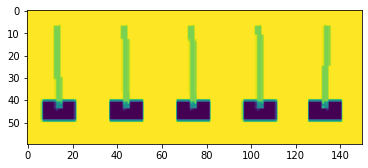

In [28]:
plt.imshow(torch.hstack([pcs[6+13][i][0] for i in range(5)]))

In [29]:
pcs[13]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [30]:
for i,pc in enumerate(pcs):
    print(i,pc!=None)

0 True
1 False
2 False
3 False
4 False
5 False
6 True
7 False
8 False
9 False
10 False
11 False
12 True
13 True
14 False
15 False
16 False
17 False
18 False
19 True
20 False
21 False
22 False
23 False
24 False
25 True
26 True
27 False
28 False
29 False
30 False
31 False
32 True
33 False
34 False
35 False
36 False
37 False
38 True
39 True
40 False
41 False
42 False
43 False
44 False
45 True
46 False
47 False
48 False
49 False
50 False
51 True
52 False
53 False
54 False
55 False
56 False
57 True
58 False
59 False
60 False
61 False
62 False
63 True
64 False
65 True
66 False
67 False
68 False
69 False
70 False
71 True
72 False
73 False
74 False
75 False
76 False
77 True
78 False
79 False
80 False
81 False
82 False
83 True
84 False
85 False
86 False
87 False
88 False
89 True
90 False
91 False
92 False
93 False
94 True


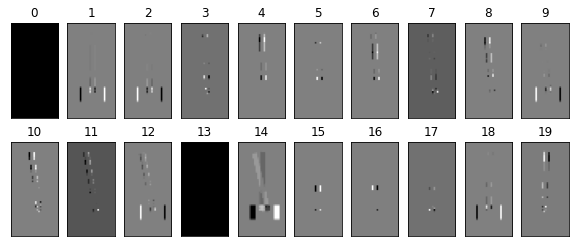

In [19]:

__, ax_ex = plt.subplots(2,10, figsize=(10,4))
for i in range(2):
    for j in range(10):
        ax_ex[i][j].imshow(pcs[i*10+j][0], cmap="gray")
        ax_ex[i][j].set_title("%d"%(i*10+j))
[axx.set_xticks([]) for axx in ax_ex.flatten()]
[axx.set_yticks([]) for axx in ax_ex.flatten()]
plt.show()

## Policy net - Convolutional case

In [19]:
class DQN_Conv(nn.Module):

    def __init__(self, action_space_dim):
        super().__init__()


        self.net_tunable = nn.Sequential(
            nn.Conv2d(1,40,(12,8), (4,4), padding=1),
            nn.ReLU(),
            nn.Conv2d(40,20, kernel_size=(6,6), stride=(3,2), padding=0),
            nn.ReLU(),
            nn.Conv2d(20,10, kernel_size=(5,5), stride=(3,2), padding=0),
            nn.ReLU(),
            nn.Flatten()
        )

        self.net_fixed = nn.Sequential(
            nn.Linear(120,100),
            nn.Tanh(),
            nn.Linear(100,50),
            nn.Tanh(),
            nn.Linear(in_features=50, out_features=action_space_dim)
        )

    def forward(self, x):
        x = self.net_tunable(x)
        x = self.net_fixed(x)
        return x

In [ ]:
class DQN_Conv_Reshape(nn.Module):

    def __init__(self, action_space_dim):
        super().__init__()


        self.net_tunable = nn.Sequential(
            nn.Conv2d(1,40,(6,4), (2,2), padding=1),
            nn.ReLU(),
            nn.Conv2d(40,20, kernel_size=(4,4), stride=(2,2), padding=0),
            nn.ReLU(),
            nn.Conv2d(20,10, kernel_size=(3,3), stride=(2,2), padding=0),
            nn.ReLU(),
            nn.Flatten()
        )

        self.net_fixed = nn.Sequential(
            nn.Linear(120,100),
            nn.Tanh(),
            nn.Linear(100,50),
            nn.Tanh(),
            nn.Linear(in_features=50, out_features=action_space_dim)
        )

    def forward(self, x):
        x = self.net_tunable(x)
        x = self.net_fixed(x)
        return x

## Fine-Tuning training function

In [21]:
policy_ft = nn.Sequential(DQN_Conv(2).net_tunable,
                     nn.Linear(120,120),
                     nn.ReLU(),
                     nn.Linear(120, 2))

print(policy_ft)

#policy_ft.load_state_dict(torch.load("policy_ft.pht"))

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 40, kernel_size=(12, 8), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 20, kernel_size=(6, 6), stride=(3, 2))
    (3): ReLU()
    (4): Conv2d(20, 10, kernel_size=(5, 5), stride=(3, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Linear(in_features=120, out_features=120, bias=True)
  (2): ReLU()
  (3): Linear(in_features=120, out_features=2, bias=True)
)


<All keys matched successfully>

In [82]:
def train_FT(policy_ft, iters, epochs):
    env = CartPole() 

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(policy_ft.parameters(), lr=1e-3, weight_decay=5e-4)

    train_loss = []
    pos=[]
    imgs=[]
    for num_episode in range(iters): 
        env.reset()
        curr_img= env.get_state(reshape=False)
        
        score = 0

        

        while not env.done:
            action, q_values = choose_action_softmax(policy_net_ang, env.state, temperature=0)
            random_error = np.random.rand()
            
            if random_error < 0.3:
                action = 1-action
            
            reward = env.take_action(action)
            curr_img = env.get_state(reshape=False)

            score += 1

            if not env.done:
                imgs.append(curr_img)
                pos.append(env.state[[2,3]])
            if score==500:
                env.done=True

        #print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

    pos = torch.Tensor(np.array(pos))
    imgs = torch.stack(imgs)
    env.close()
    print(f"Set lenght: {pos.shape[0]}")

    for j in tqdm(range(epochs)):
        split_index = torch.split(torch.Tensor(np.random.permutation(pos.shape[0])),200)
        train_loss_provv = []
        for i in range(len(split_index)):

            indexes = split_index[i].int().tolist()
            out = policy_ft(imgs[indexes])

            loss = loss_fn(pos[indexes], out)
            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()

            # Backpropagation
            policy_ft.zero_grad()
            loss.backward()

            # Update the weights
            nn.utils.clip_grad_norm_(policy_ft.parameters(), 2)
            optimizer.step()

            # Save train loss for this batch
            train_loss_provv.append(loss_batch)
        train_loss.append(np.mean(train_loss_provv))
        #print(f"Iteration nr {j}:", train_loss[-1])
    
    
    return policy_ft, train_loss
    #return pos, imgs

In [83]:
policy_ft, train_loss = train_FT(policy_ft,70,100)

Set lenght: 3637


  0%|          | 0/100 [00:00<?, ?it/s]

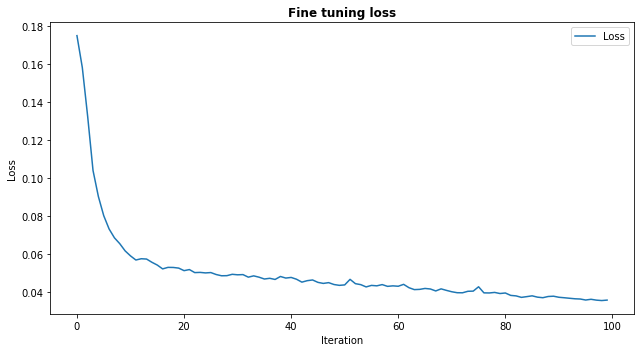

In [84]:
plt.figure(figsize=(9,5))

plt.plot(train_loss, label="Loss")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Fine tuning loss", fontweight="bold")
plt.tight_layout()

In [85]:
#torch.save(policy_ft.state_dict(), "policy_ft.pht")

## Update function - Convolutional case

In [22]:
def update_step_conv(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, sparsity):
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.stack([s[0] for s in batch])
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.stack([s[2] for s in batch if s[2] is not None]) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)
  
    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)

    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.cpu().gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.cpu().max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape
    # Compute the Huber loss
    sparse_loss = sum(torch.abs(p).sum() for p in policy_net.parameters())

    loss = loss_fn(state_action_values, expected_state_action_values) + sparsity* sparse_loss

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    #nn.utils.clip_grad_norm_(policy_net.parameters(), 10)
    optimizer.step()

In [23]:
def test_conv(policy_net_test, reshape=True):
    # Initialize the Gym environment
    env = CartPole() 
    #env.env.seed(1) # Set a random seed for the environment (reproducible results)

    # This is for creating the output video in Colab, not required outside Colab
    #env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

    # Let's try for a total of 10 episodes
    qva_list=[]
    act_list=[]
    pos_list=[]
    img_list=[]
    for num_episode in range(10): 
        env.reset()
        
        curr_img= env.get_state(reshape=reshape)
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        qva=[]
        acts=[]
        pos=[]
        imgs=[]
        # Go on until the pole falls off
        while not env.done:

            #action, q_values = choose_action_epsilon_greedy(policy_net_conv, curr_img.unsqueeze(0), epsilon=epsilon)
            action, q_values = choose_action_softmax(policy_net_test, curr_img.unsqueeze(0), temperature=tau)
            qva.append(q_values)
            acts.append(action)
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            reward = env.take_action(action)
            imgs.append(curr_img)
            next_img = env.get_state(reshape=reshape)
            pos.append(env.state[2])
            # Update the final score (+1 for each step)
            score += 1
            # Apply penalty for bad state
            if env.done: # if the pole has fallen down 
                next_img = None
            if score==500:
                env.done=True
            # Visually render the environment (disable to speed up the training)
            curr_img = next_img
        print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
        act_list.append(acts)
        qva_list.append(qva)
        pos_list.append(pos)
        img_list.append(imgs)
    env.close()

    return qva_list, act_list, pos_list, img_list

## Training

### First method

In [ ]:
exploration_profile_conv = exp_exploration(4,5000,7, plott=False)

In [ ]:
gamma = 0.97
replay_memory_capacity = 10000
lr = 5e-4
target_net_update_steps = 10
batch_size = 200
bad_state_penalty = 0
min_samples_for_training = 1000



env = CartPole()


replay_mem_img = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net_conv = DQN_Conv_Reshape(action_space_dim)#.to(device)
#policy_net_conv.load_state_dict(torch.load('CartPole_conv.pth'))

### Initialize the target network with the same weights of the policy network
target_net_conv = DQN_Conv_Reshape(action_space_dim)#.to(device)
target_net_conv.load_state_dict(policy_net_conv.state_dict())

optimizer_conv = torch.optim.Adam(policy_net_conv.parameters(), lr=lr)

score_list_conv=[]
qva_rec=[]

#for episode_num, epsilon in enumerate(tqdm(np.arange(0,1,0.01)[::-1])):
for episode_num, tau in enumerate(tqdm(exploration_profile_conv)):

    # Reset the environment and get the initial state
    env.reset()
    
    curr_img= env.get_state()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    qva=[]
    acts=[]
    # Go on until the pole falls off
    while not env.done:

        # Choose the action following the policy
        
        #action, q_values = choose_action_epsilon_greedy(policy_net_conv, curr_img.unsqueeze(0), epsilon=epsilon)
        action, q_values = choose_action_softmax(policy_net_conv, curr_img.unsqueeze(0), temperature=tau)

        qva.append(q_values)
        acts.append(action)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        reward = env.take_action(action)
        next_img = env.get_state()
        
        ang_weight = 10
        reward = reward - ang_weight * np.abs(env.state[2]) 
        #print(reward)

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if env.done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_img = None

        if score==500:
            env.done=True

        # Update the replay memory
        replay_mem_img.push(curr_img, action, next_img, reward)

        # Update the network
        if len(replay_mem_img) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step_conv(policy_net_conv, target_net_conv, replay_mem_img, gamma, optimizer_conv, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        curr_img = next_img

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net_conv.load_state_dict(policy_net_conv.state_dict()) # This will copy the weights of the policy network to the target network

    if episode_num%200==0:
        qva_rec.append([acts,qva])

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau} - Q-val {q_values}") # Print the final score
    score_list_conv.append(score)

env.close()



  0%|          | 0/5000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 20 - Temperature: 4.0 - Q-val [0.05601949 0.1331362 ]
EPISODE: 2 - FINAL SCORE: 34 - Temperature: 3.9922438059088448 - Q-val [0.05683975 0.13346124]
EPISODE: 3 - FINAL SCORE: 12 - Temperature: 3.984502650534692 - Q-val [0.05577471 0.13385244]
EPISODE: 4 - FINAL SCORE: 42 - Temperature: 3.976776504718523 - Q-val [0.05638467 0.1337224 ]
EPISODE: 5 - FINAL SCORE: 26 - Temperature: 3.9690653393578565 - Q-val [0.05641425 0.13370895]
EPISODE: 6 - FINAL SCORE: 18 - Temperature: 3.9613691254066388 - Q-val [0.05643186 0.13325684]
EPISODE: 7 - FINAL SCORE: 11 - Temperature: 3.9536878338751342 - Q-val [0.05561744 0.13600133]
EPISODE: 8 - FINAL SCORE: 18 - Temperature: 3.946021435829816 - Q-val [0.0567816  0.13342583]
EPISODE: 9 - FINAL SCORE: 71 - Temperature: 3.938369902393258 - Q-val [0.05644951 0.13361473]
EPISODE: 10 - FINAL SCORE: 14 - Temperature: 3.9307332047440253 - Q-val [0.05623809 0.13396154]
Updating target network...
EPISODE: 11 - 

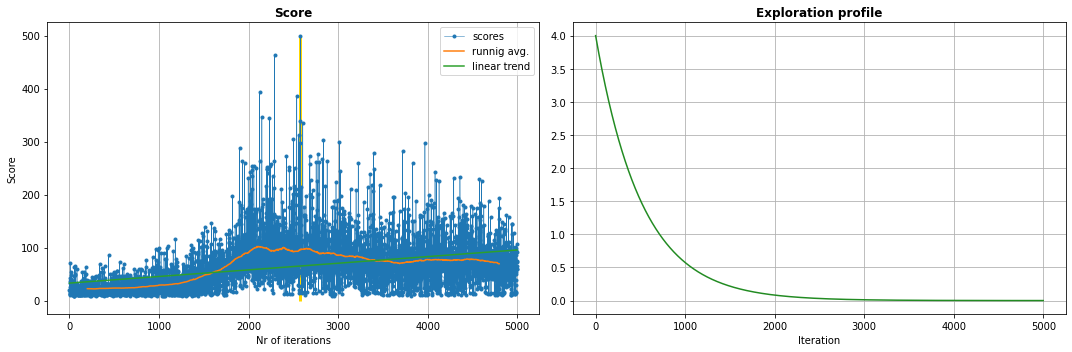

Game solved at iteration nr 2578
Avarage score: 64.190
Number of succesflu games: 1


In [ ]:
CartPoleShowResults(score_list_conv, exploration_profile_conv, dist=200,interp=True, top_line=False)
print("Avarage score: %.3f" %(np.mean(score_list_conv)))
print("Number of succesflu games: %d" %(len(np.where(np.array(score_list_conv)==500)[0])))

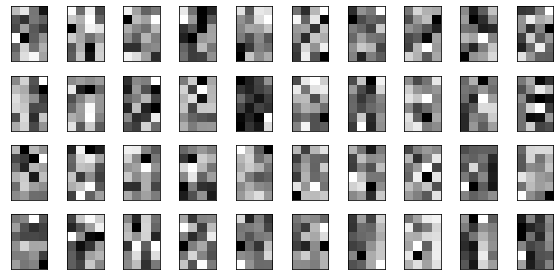

In [ ]:
__, axwe=plt.subplots(4,10, figsize=(8,4))
axwe=axwe.flatten()
[axx.set_xticks([]) for axx in axwe]
[axx.set_yticks([]) for axx in axwe]

for i in range(40):
    axwe[i].imshow(policy_net_conv.net_tunable[0].weight.detach().numpy()[i][0], cmap="gray")

plt.tight_layout()

#### Testing

In [ ]:
qva_conv, act_conv, pos_conv, img_conv = test_conv(policy_net_conv)

EPISODE 1 - FINAL SCORE: 79
EPISODE 2 - FINAL SCORE: 65
EPISODE 3 - FINAL SCORE: 78
EPISODE 4 - FINAL SCORE: 28
EPISODE 5 - FINAL SCORE: 47
EPISODE 6 - FINAL SCORE: 62
EPISODE 7 - FINAL SCORE: 84
EPISODE 8 - FINAL SCORE: 108
EPISODE 9 - FINAL SCORE: 89
EPISODE 10 - FINAL SCORE: 17


In [ ]:
nsamp=4

qva_in = np.array(qva_conv[nsamp])

plot_cart = figure(plot_width=800, plot_height=400,
             x_axis_label='Iteration',
             x_axis_location='below',
             y_axis_label='Score',
             y_axis_location='left',
             y_axis_type='linear',
             )

x_ax = np.arange(len(np.array(qva_in)[:,0])) 

plot_cart.line(x_ax, np.array(qva_in)[:,0], color="blue", legend_label="Left")
plot_cart.line(x_ax, np.array(qva_in)[:,1], color='orange', legend_label="Right")

for i in range(len(qva_in)):
    mark=[".","."]
    wh=int(qva_in[i,0]<qva_in[i,1])
    mark[wh]="o"
    plot_cart.scatter(i,qva_in[i][0], color="blue", marker=mark[0])
    plot_cart.scatter(i,qva_in[i][1], color="orange", marker=mark[1])

plot_cart.extra_y_ranges = {"foo label": Range1d(start=-0.48, end=0.48)}
plot_cart.add_layout(LinearAxis( y_range_name='foo label', axis_label='Angle'), 'right')

plot_cart.line(x_ax, pos_conv[nsamp], y_range_name='foo label' ,color='firebrick', alpha=0.5, legend_label="Angle", line_width=3)
plot_cart.line(x_ax, np.zeros(len(x_ax)), y_range_name='foo label' ,color='black', line_width=1)

plot_cart.axis.axis_line_color = "gray"

plot_cart.legend.location = "bottom_left"
plot_cart.legend.click_policy="hide"

show(plot_cart)

### Second method

In [24]:
for param_name, param in policy_ft[0].named_parameters():
    param.requires_grad = False  

policy_net_conv = nn.Sequential(
    policy_ft[0],
    DQN_Conv(2).net_fixed
)

print(policy_net_conv)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 40, kernel_size=(12, 8), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 20, kernel_size=(6, 6), stride=(3, 2))
    (3): ReLU()
    (4): Conv2d(20, 10, kernel_size=(5, 5), stride=(3, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Sequential(
    (0): Linear(in_features=120, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [25]:
for param_name, param in policy_net_conv.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

0.0.weight 	- requires_grad=False
0.0.bias 	- requires_grad=False
0.2.weight 	- requires_grad=False
0.2.bias 	- requires_grad=False
0.4.weight 	- requires_grad=False
0.4.bias 	- requires_grad=False
1.0.weight 	- requires_grad=True
1.0.bias 	- requires_grad=True
1.2.weight 	- requires_grad=True
1.2.bias 	- requires_grad=True
1.4.weight 	- requires_grad=True
1.4.bias 	- requires_grad=True


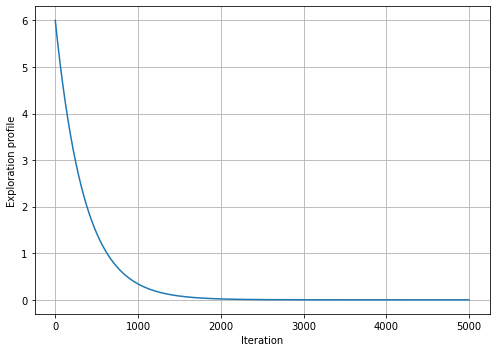

In [31]:
exploration_profile_conv = exp_exploration(6,5000,8, plott=True)

In [33]:
gamma = 0.97
replay_memory_capacity = 10000
lr = 5e-4
target_net_update_steps = 10
batch_size = 200
bad_state_penalty = 0
min_samples_for_training = 1000




env = CartPole()


replay_mem_img = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
#policy_net_conv = DQN_Conv(action_space_dim)#.to(device)
#policy_net_conv.load_state_dict(torch.load('CartPole_conv.pth'))


target_net_conv = nn.Sequential(
    DQN_Conv(2).net_tunable,
    DQN_Conv(2).net_fixed
)
target_net_conv.load_state_dict(policy_net_conv.state_dict())

optimizer_conv = torch.optim.Adam(policy_net_conv.parameters(), lr=lr)

score_list_conv=[]
qva_rec=[]

for episode_num, tau in enumerate(tqdm(exploration_profile_conv)):

    env.reset()
    
    curr_img= env.get_state(reshape=False)
    score = 0
    qva=[]
    acts=[]
    
    while not env.done:

        action, q_values = choose_action_softmax(policy_net_conv, curr_img.unsqueeze(0), temperature=tau)

        qva.append(q_values)
        acts.append(action)
        
        reward = env.take_action(action)
        next_img = env.get_state(reshape=False)
        
        ang_weight = 10
        reward = reward - ang_weight * np.abs(env.state[2]) 
        
        score += 1

        
        if env.done:
            reward += bad_state_penalty
            next_img = None

        if score==500:
            env.done=True

        
        replay_mem_img.push(curr_img, action, next_img, reward)

        
        if len(replay_mem_img) > min_samples_for_training: 
            update_step_conv(policy_net_conv, target_net_conv, replay_mem_img, gamma, optimizer_conv, loss_fn, batch_size, sparsity=1e-4)

        
        curr_img = next_img

    
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net_conv.load_state_dict(policy_net_conv.state_dict()) 

    if episode_num%200==0:
        qva_rec.append([acts,qva])

    
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau} - Q-val {q_values}") # Print the final score
    score_list_conv.append(score)

env.close()



  0%|          | 0/5000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 26 - Temperature: 6.0 - Q-val [ 0.05347759 -0.12587039]
EPISODE: 2 - FINAL SCORE: 15 - Temperature: 5.982823731211284 - Q-val [-2.6738615 -2.5748167]
EPISODE: 3 - FINAL SCORE: 31 - Temperature: 5.965696633094875 - Q-val [-2.2578914 -2.5106385]
EPISODE: 4 - FINAL SCORE: 18 - Temperature: 5.94861856488941 - Q-val [-1.6518936 -1.6077708]
EPISODE: 5 - FINAL SCORE: 13 - Temperature: 5.931589386236483 - Q-val [-1.3430827 -1.2912724]
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 5.914608957179494 - Q-val [-1.8600857 -2.0693576]
EPISODE: 7 - FINAL SCORE: 10 - Temperature: 5.897677138162501 - Q-val [-2.1504455 -2.2658706]
EPISODE: 8 - FINAL SCORE: 20 - Temperature: 5.880793790029068 - Q-val [-2.1700099 -2.2251198]
EPISODE: 9 - FINAL SCORE: 33 - Temperature: 5.863958774021121 - Q-val [-1.3733783 -1.6712407]
EPISODE: 10 - FINAL SCORE: 12 - Temperature: 5.847171951777815 - Q-val [1.0272826 1.403242 ]
Updating target network...
EPISODE: 11 - FINAL S

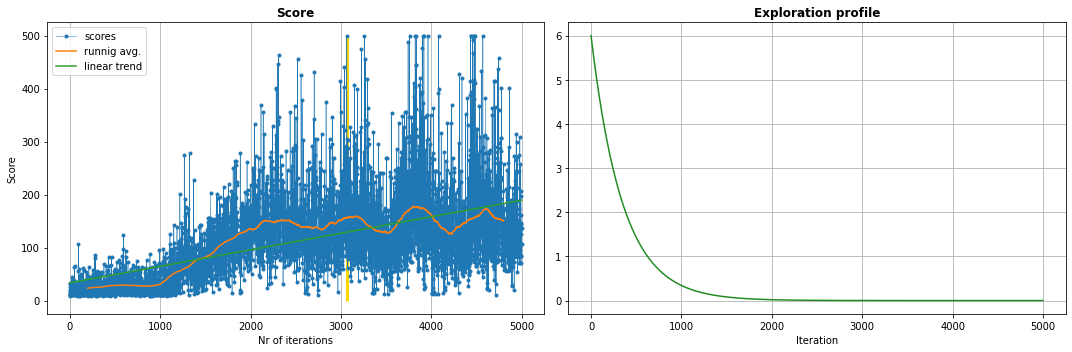

Game solved at iteration nr 3065
Avarage score: 111.404
Number of succesflu games: 15


In [40]:
CartPoleShowResults(score_list_conv, exploration_profile_conv, dist=200,interp=True, top_line=False)
print("Avarage score: %.3f" %(np.mean(score_list_conv)))
print("Number of succesflu games: %d" %(len(np.where(np.array(score_list_conv)==500)[0])))

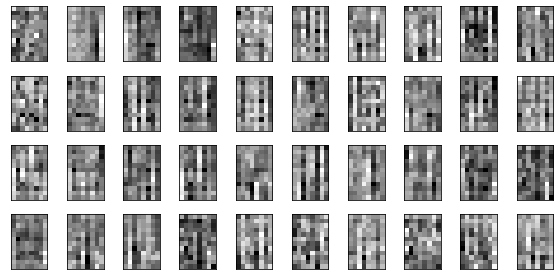

In [36]:
__, axwe=plt.subplots(4,10, figsize=(8,4))
axwe=axwe.flatten()
[axx.set_xticks([]) for axx in axwe]
[axx.set_yticks([]) for axx in axwe]

for i in range(40):
    axwe[i].imshow(policy_net_conv[0][0].weight.detach().numpy()[i][0], cmap="gray")

plt.tight_layout()

#### Testing

In [37]:
qva_conv, act_conv, pos_conv, img_conv = test_conv(policy_net_conv)

EPISODE 1 - FINAL SCORE: 153
EPISODE 2 - FINAL SCORE: 113
EPISODE 3 - FINAL SCORE: 104
EPISODE 4 - FINAL SCORE: 160
EPISODE 5 - FINAL SCORE: 302
EPISODE 6 - FINAL SCORE: 105
EPISODE 7 - FINAL SCORE: 213
EPISODE 8 - FINAL SCORE: 137
EPISODE 9 - FINAL SCORE: 141
EPISODE 10 - FINAL SCORE: 207


In [39]:
nsamp=4

qva_in = np.array(qva_conv[nsamp])

plot_cart = figure(plot_width=800, plot_height=400,
             x_axis_label='Iteration',
             x_axis_location='below',
             y_axis_label='Score',
             y_axis_location='left',
             y_axis_type='linear',
             )

x_ax = np.arange(len(np.array(qva_in)[:,0])) 

plot_cart.line(x_ax, np.array(qva_in)[:,0], color="blue", legend_label="Left")
plot_cart.line(x_ax, np.array(qva_in)[:,1], color='orange', legend_label="Right")

for i in range(len(qva_in)):
    mark=[".","."]
    wh=int(qva_in[i,0]<qva_in[i,1])
    mark[wh]="o"
    plot_cart.scatter(i,qva_in[i][0], color="blue", marker=mark[0])
    plot_cart.scatter(i,qva_in[i][1], color="orange", marker=mark[1])

plot_cart.extra_y_ranges = {"foo label": Range1d(start=-0.48, end=0.48)}
plot_cart.add_layout(LinearAxis( y_range_name='foo label', axis_label='Angle'), 'right')

plot_cart.line(x_ax, pos_conv[nsamp], y_range_name='foo label' ,color='firebrick', alpha=0.5, legend_label="Angle", line_width=3)
plot_cart.line(x_ax, np.zeros(len(x_ax)), y_range_name='foo label' ,color='black', line_width=1)

plot_cart.axis.axis_line_color = "gray"

plot_cart.legend.location = "bottom_left"
plot_cart.legend.click_policy="hide"

show(plot_cart)

# MOUNTAINCAR-V0

    """
    Description:
        The agent (a car) is started at the bottom of a valley. For any given
        state the agent may choose to accelerate to the left, right or cease
        any acceleration.
    Source:
        The environment appeared first in Andrew Moore's PhD Thesis (1990).
    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
    Starting State:
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200
    """

## Training

In [13]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim_car = env.observation_space.shape[0]
action_space_dim_car = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim_car}")
print(f"ACTION SPACE SIZE: {action_space_dim_car}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


In [33]:
def TrainingLoopAdvancedCar(initial_value=5,
                         num_iterations=600,
                         gamma = 0.97,
                         replay_memory_capacity = 10000,
                         lr = 5e-3, 
                         target_net_update_steps = 10, 
                         batch_size = 128,
                         bad_state_penalty = 0, 
                         min_samples_for_training = 1000,
                         pos_weight=1,
                         vel_weight=0.5,
                         printt=True,
                         env_show=True):

    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

    env = gym.make('MountainCar-v0') 
    env.seed(1)

    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim_car, action_space_dim_car)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim_car, action_space_dim_car)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)

    score_list=[]
    pos_extr=[]
    vel_extr=[]
    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        pos_list=[]
        vel_list=[]
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            reward = reward + pos_weight * (np.abs(state[0]+0.525))**2

            reward = reward + vel_weight * (state[1])

            score -= 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            if env_show:
                env.render()

            # Set the current state for the next iteration
            pos_list.append(state[0])
            vel_list.append(state[1])
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            if printt: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if printt: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        score_list.append(score)
        pos_extr.append([min(pos_list), max(pos_list)])
        vel_extr.append([min(vel_list), max(vel_list)])

    env.close()

    return policy_net, target_net, score_list, pos_extr, vel_extr, env, exploration_profile

In [29]:
def test(policy_net_test):
    # Initialize the Gym environment
    env = gym.make('MountainCar-v0') 
    env.seed(1) # Set a random seed for the environment (reproducible results)

    # This is for creating the output video in Colab, not required outside Colab
    #env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

    # Let's try for a total of 10 episodes
    qva_list=[]
    act_list=[]
    pos_list=[]
    for num_episode in range(10): 
        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        actions=[]
        qvals=[]
        pos=[]
        # Go on until the pole falls off or the score reach 490
        while not done:
            # Choose the best action (temperature 0)
            action, q_values = choose_action_softmax(policy_net_test, state, temperature=0)
            qvals.append(q_values)
            actions.append(action)
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            pos.append(state[0])
            # Visually render the environment
            #env.render()
            # Update the final score (+1 for each step)
            score += reward 
            # Set the current state for the next iteration
            state = next_state
            # Check if the episode ended (the pole fell down)
        # Print the final score
        print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
        act_list.append(actions)
        qva_list.append(qvals)
        pos_list.append(pos)
    env.close()

    return qva_list, act_list, pos_list

In [34]:
np.random.seed(0)
torch.manual_seed(20)

policy_net_mountain, target_net, score_list, pos_extr, vel_extr, env_car, exp_mount = TrainingLoopAdvancedCar(num_iterations=1000, 
                                                                               pos_weight=0.1,
                                                                               vel_weight=0.2,
                                                                               env_show=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -200 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -200 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -200 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -200 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -200 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: -200 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -200 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -200 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -200 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -200 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -200 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -200 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: -200 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: -200 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: -200 - Temperature: 4.367737444

## Results

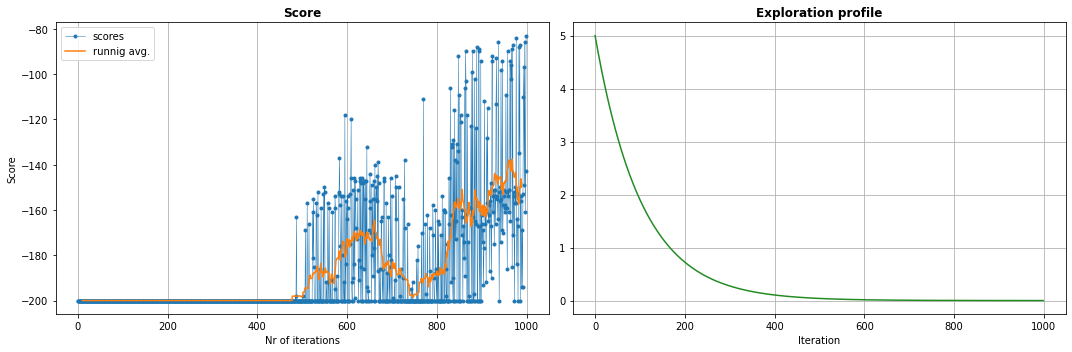

In [35]:
CartPoleShowResults(score_list, exp_mount, dist=10, top_line=False)

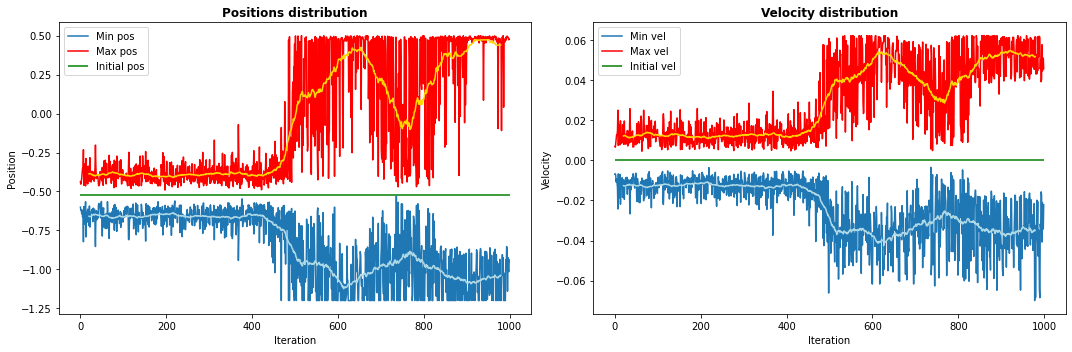

In [36]:
pos_extr=np.array(pos_extr)
vel_extr=np.array(vel_extr)

dist=20

runn_avg_pos=[]
runn_avg_vel=[]
for i in range(dist,len(pos_extr[:,0])-dist):
    runn_avg_pos.append(np.mean(pos_extr[i-dist:i+dist],axis=0))
    runn_avg_vel.append(np.mean(vel_extr[i-dist:i+dist],axis=0))

runn_avg_pos=np.array(runn_avg_pos)
runn_avg_vel=np.array(runn_avg_vel)

__, (ax_pos, ax_vel) = plt.subplots(1,2,figsize=(15,5))

#position
ax_pos.plot(pos_extr[:,0], color="C0", label="Min pos")
ax_pos.plot(np.arange(dist, len(pos_extr)-dist),runn_avg_pos[:,0], color="lightblue")
ax_pos.plot(np.array(pos_extr)[:,1], color="red", label="Max pos")
ax_pos.plot(np.arange(dist, len(pos_extr)-dist),runn_avg_pos[:,1], color="gold")
ax_pos.hlines(-0.525, 0,1000, color="green", label="Initial pos")

ax_pos.set_title("Positions distribution", fontweight="bold")
ax_pos.legend()
ax_pos.set_xlabel("Iteration")
ax_pos.set_ylabel("Position")

#velocity
ax_vel.plot(vel_extr[:,0], color="C0", label="Min vel")
ax_vel.plot(np.arange(dist, len(vel_extr)-dist),runn_avg_vel[:,0], color="lightblue")
ax_vel.plot(np.array(vel_extr)[:,1], color="red", label="Max vel")
ax_vel.plot(np.arange(dist, len(vel_extr)-dist),runn_avg_vel[:,1], color="gold")
ax_vel.hlines(0, 0,1000, color="green", label="Initial vel")

ax_vel.set_title("Velocity distribution", fontweight="bold")
ax_vel.legend()
ax_vel.set_xlabel("Iteration")
ax_vel.set_ylabel("Velocity")

plt.tight_layout()

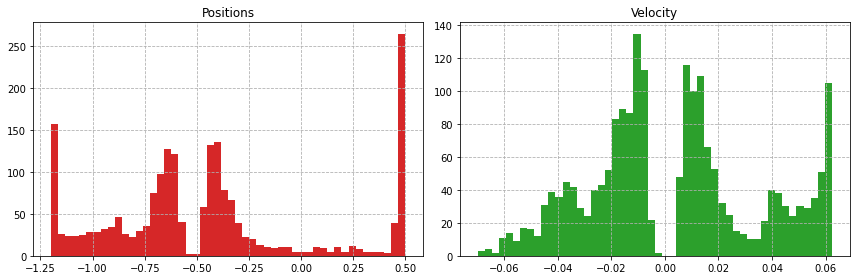

In [37]:
__, ax_hist = plt.subplots(1,2, figsize=(12,4))

ax_hist[0].hist(np.array(pos_extr).flatten(), 50, color="C3")
ax_hist[0].set_title("Positions")
ax_hist[0].grid(linestyle="--")

ax_hist[1].hist(np.array(vel_extr).flatten(), 50, color="C2")
ax_hist[1].set_title("Velocity")
ax_hist[1].grid(linestyle="--")

plt.tight_layout()

## Test

In [38]:
qva_mount, act_mount, pos_mount = test(policy_net_mountain)

EPISODE 1 - FINAL SCORE: -88.0
EPISODE 2 - FINAL SCORE: -151.0
EPISODE 3 - FINAL SCORE: -150.0
EPISODE 4 - FINAL SCORE: -150.0
EPISODE 5 - FINAL SCORE: -90.0
EPISODE 6 - FINAL SCORE: -152.0
EPISODE 7 - FINAL SCORE: -153.0
EPISODE 8 - FINAL SCORE: -151.0
EPISODE 9 - FINAL SCORE: -95.0
EPISODE 10 - FINAL SCORE: -148.0


In [42]:
nsamp=4

qva_in = qva_mount[nsamp]
acts_in=act_mount[nsamp]

plot = figure(plot_width=800, plot_height=400,
             x_axis_label='Iteration',
             x_axis_location='below',
             y_axis_label='Score',
             y_axis_location='left',
             y_axis_type='linear',
             )

x_ax = np.arange(len(np.array(qva_in)[:,0])) 

plot.line(x_ax, np.array(qva_in)[:,0], color="blue", legend_label="Left")
plot.line(x_ax, np.array(qva_in)[:,1], color='orange', legend_label="Stop")
plot.line(x_ax, np.array(qva_in)[:,2], color='green', legend_label="Right")

for i in range(len(qva_in)):
    mark=[".",".","."]
    mark[acts_in[i]]="*"
    plot.scatter(i,qva_in[i][0], color="blue", marker=mark[0])
    plot.scatter(i,qva_in[i][1], color="orange", marker=mark[1])
    plot.scatter(i,qva_in[i][2], color="green", marker=mark[2])

plot.extra_y_ranges = {"foo label": Range1d(start=-1.4, end=0.5)}
plot.add_layout(LinearAxis( y_range_name='foo label', axis_label='Position'), 'right')

plot.line(x_ax, pos_mount[nsamp], y_range_name='foo label' ,color='firebrick', alpha=0.5, legend_label="Position", line_width=3)
plot.axis.axis_line_color = "gray"

plot.legend.location = "top_left"
plot.legend.click_policy="hide"

show(plot)

In [38]:
env = gym.make("Breakout-v0")


In [29]:
# Initialize the Gym environment
env = gym.make("Breakout-v0")
env.seed(0) # Set a random seed for the environment (reproducible results)

thestate=[]
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    for i in range(19):
      # Choose a random action
      action = random.choice([0,1,2,3])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state = env.step(action)
      print(next_state)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      thestate.append(env.render(mode='rgb_array'))
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0.0, False, {'lives': 5})
(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
    

In [14]:
thestate=np.array(thestate)
thestate.shape

(190, 210, 160, 3)

In [15]:
import PIL

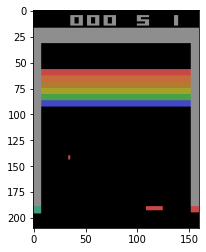

In [38]:
plt.imshow(thestate[25])

In [44]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [40]:
cum_sum = 0
cum_sum_list = []
points = np.logspace(1,6,20)
for r in tqdm(points):
    #print("Nr iterations %.4f" %(r))
    for i in range(int(r)):
        cum_sum += np.prod(np.random.choice([-1,1],2))
    #print(cum_sum/(r))
    cum_sum_list.append(cum_sum/(r))

100%|██████████| 20/20 [00:41<00:00,  2.05s/it]


In [45]:
def f(x,a,b):
    return a*np.sqrt(x)+b

pars = curve_fit(f, r, cum_sum_list, [0.1,0.2])

In [46]:
pars

(array([ 7.12096437e+00, -7.12096563e+03]),
 array([[-5.69914716e+06,  5.69914714e+09],
        [ 5.69914714e+09, -5.69914713e+12]]))

In [59]:
f(points, pars[0][0], pars[0][1])

array([-7.09844716e+03, -7.09047841e+03, -7.07968971e+03, -7.06508315e+03,
       -7.04530767e+03, -7.01853412e+03, -6.98228605e+03, -6.93321066e+03,
       -6.86676864e+03, -6.77681439e+03, -6.65502746e+03, -6.49014304e+03,
       -6.26690996e+03, -5.96468000e+03, -5.55549806e+03, -5.00151637e+03,
       -4.25149376e+03, -3.23605602e+03, -1.86127905e+03, -1.26104524e-03])

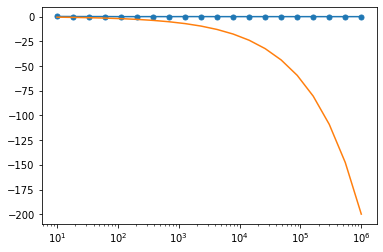

In [63]:
points = np.logspace(1,6,20)
plt.semilogx(points, np.abs(cum_sum_list), ".-", markersize=10)
plt.semilogx(points, f(points, -0.2,0.1))
